In [1]:
import torch
from torch.utils.data import DataLoader
import albumentations as A
from datasets import GTA5, CityScapes
from models.deeplabv2.deeplabv2 import get_deeplab_v2
from models.bisenet.build_bisenet import BiSeNet
from training import train
from model_evaluation import save_results
from visualization import  plot_loss, plot_mIoU, plot_IoU
from config import BATCH_SIZE, NC, NUM_WORKERS, CITYSCAPE_SIZE, GTA5_SIZE, EPOCHS, CITYSCAPES_MEAN, CITYSCAPES_STD, GTA5_MEAN, GTA5_STD
torch.cuda.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [2]:

transforms = A.Compose([
    A.Resize(CITYSCAPE_SIZE[0], CITYSCAPE_SIZE[1]),
])
transforms_GTA5 = A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),


])

cityscapes_train_dataset = CityScapes('./Cityscapes', 'train', transform=transforms)
cityscapes_test_dataset = CityScapes('./Cityscapes', 'val', transform=transforms)
GTA5_dataset = GTA5('./GTA5', transform=transforms_GTA5)

cityscapes_train_dataloader = DataLoader(cityscapes_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
cityscapes_test_dataloader = DataLoader(cityscapes_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# cityscapes_mean, city_scapes_std = calculate_mean_std(cityscapes_train_dataloader)
# GTA5_mean, GTA5_std = calculate_mean_std(GTA5_dataloader)

len(cityscapes_train_dataloader)

393

## 2.1 DeepLabV2

In [ ]:

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
init_lr = 2.5e-4
model_deeplab = get_deeplab_v2(num_classes=19, pretrain=True, pretrain_model_path='./models/deeplab_resnet_pretrained_imagenet.pth').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_deeplab = torch.nn.DataParallel(model_deeplab).to(device)
optimizer_deeplab = torch.optim.SGD(model_deeplab.parameters(), lr=init_lr, momentum=0.9, weight_decay=5e-4)

deeplab_result = train(model = model_deeplab,
                       optimizer = optimizer_deeplab,
                       loss_fn = loss_fn, 
                       train_dataloader = cityscapes_train_dataloader,
                       validation_dataloader = cityscapes_test_dataloader, 
                       epochs = EPOCHS,
                       device = device,
                       model_name = "deeplab",
                       class_number= NC)

In [ ]:
save_results(model_deeplab, deeplab_result, "deeplab_performance_metrics_2_1", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100, device=device)
plot_loss(deeplab_result, "DeepLabV2", "step2_1", "CityScapes", "CityScapes")
plot_mIoU(deeplab_result, "DeepLabV2", "step2_1", "CityScapes", "CityScapes")
plot_IoU(deeplab_result, "DeepLabV2", "step2_1", "CityScapes", "CityScapes")

torch.save(model_deeplab.state_dict(), "./checkpoints/deeplab_model_2_1.pth")

## 2.2 BiseNet


In [3]:
init_lr = 2.5e-4
model_bisenet = BiSeNet(NC, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet = torch.nn.DataParallel(model_bisenet).to(device)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer_bisenet = torch.optim.Adam(model_bisenet.parameters(), lr=init_lr)

bisenet_result_2_2 = train(model = model_bisenet,
                           optimizer = optimizer_bisenet,
                           loss_fn = loss_fn, 
                           train_dataloader = cityscapes_train_dataloader,
                           validation_dataloader = cityscapes_test_dataloader, 
                           epochs = EPOCHS,
                           device = device,
                           model_name = "bisenet",
                           class_number= NC)



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 2.328399660781443, Validation Loss: 0.4589791975021362
Train mIoU: 0.2694602658201498, Validation mIoU: 0.3092789570209043
Epoch: 1
Train Loss: 1.1704158514510585, Validation Loss: 0.3584358901977539
Train mIoU: 0.3463951828365594, Validation mIoU: 0.3493301007293158
Epoch: 2
Train Loss: 0.9436416820108738, Validation Loss: 0.36293875670433046
Train mIoU: 0.3818971123511008, Validation mIoU: 0.3597354625143725
Epoch: 3
Train Loss: 0.8238380426213942, Validation Loss: 0.3184667068719864
Train mIoU: 0.40906300892401576, Validation mIoU: 0.3684123845899624
Epoch: 4
Train Loss: 0.7387997727206038, Validation Loss: 0.2856871337890625
Train mIoU: 0.4359047599917407, Validation mIoU: 0.4032455405527543
Epoch: 5
Train Loss: 0.6487014335378739, Validation Loss: 0.2844527626037598
Train mIoU: 0.4642820738827861, Validation mIoU: 0.407830964468532
Epoch: 6
Train Loss: 0.6031804780165354, Validation Loss: 0.25699877393245696
Train mIoU: 0.4809008596522995, Validation mIoU: 0.4

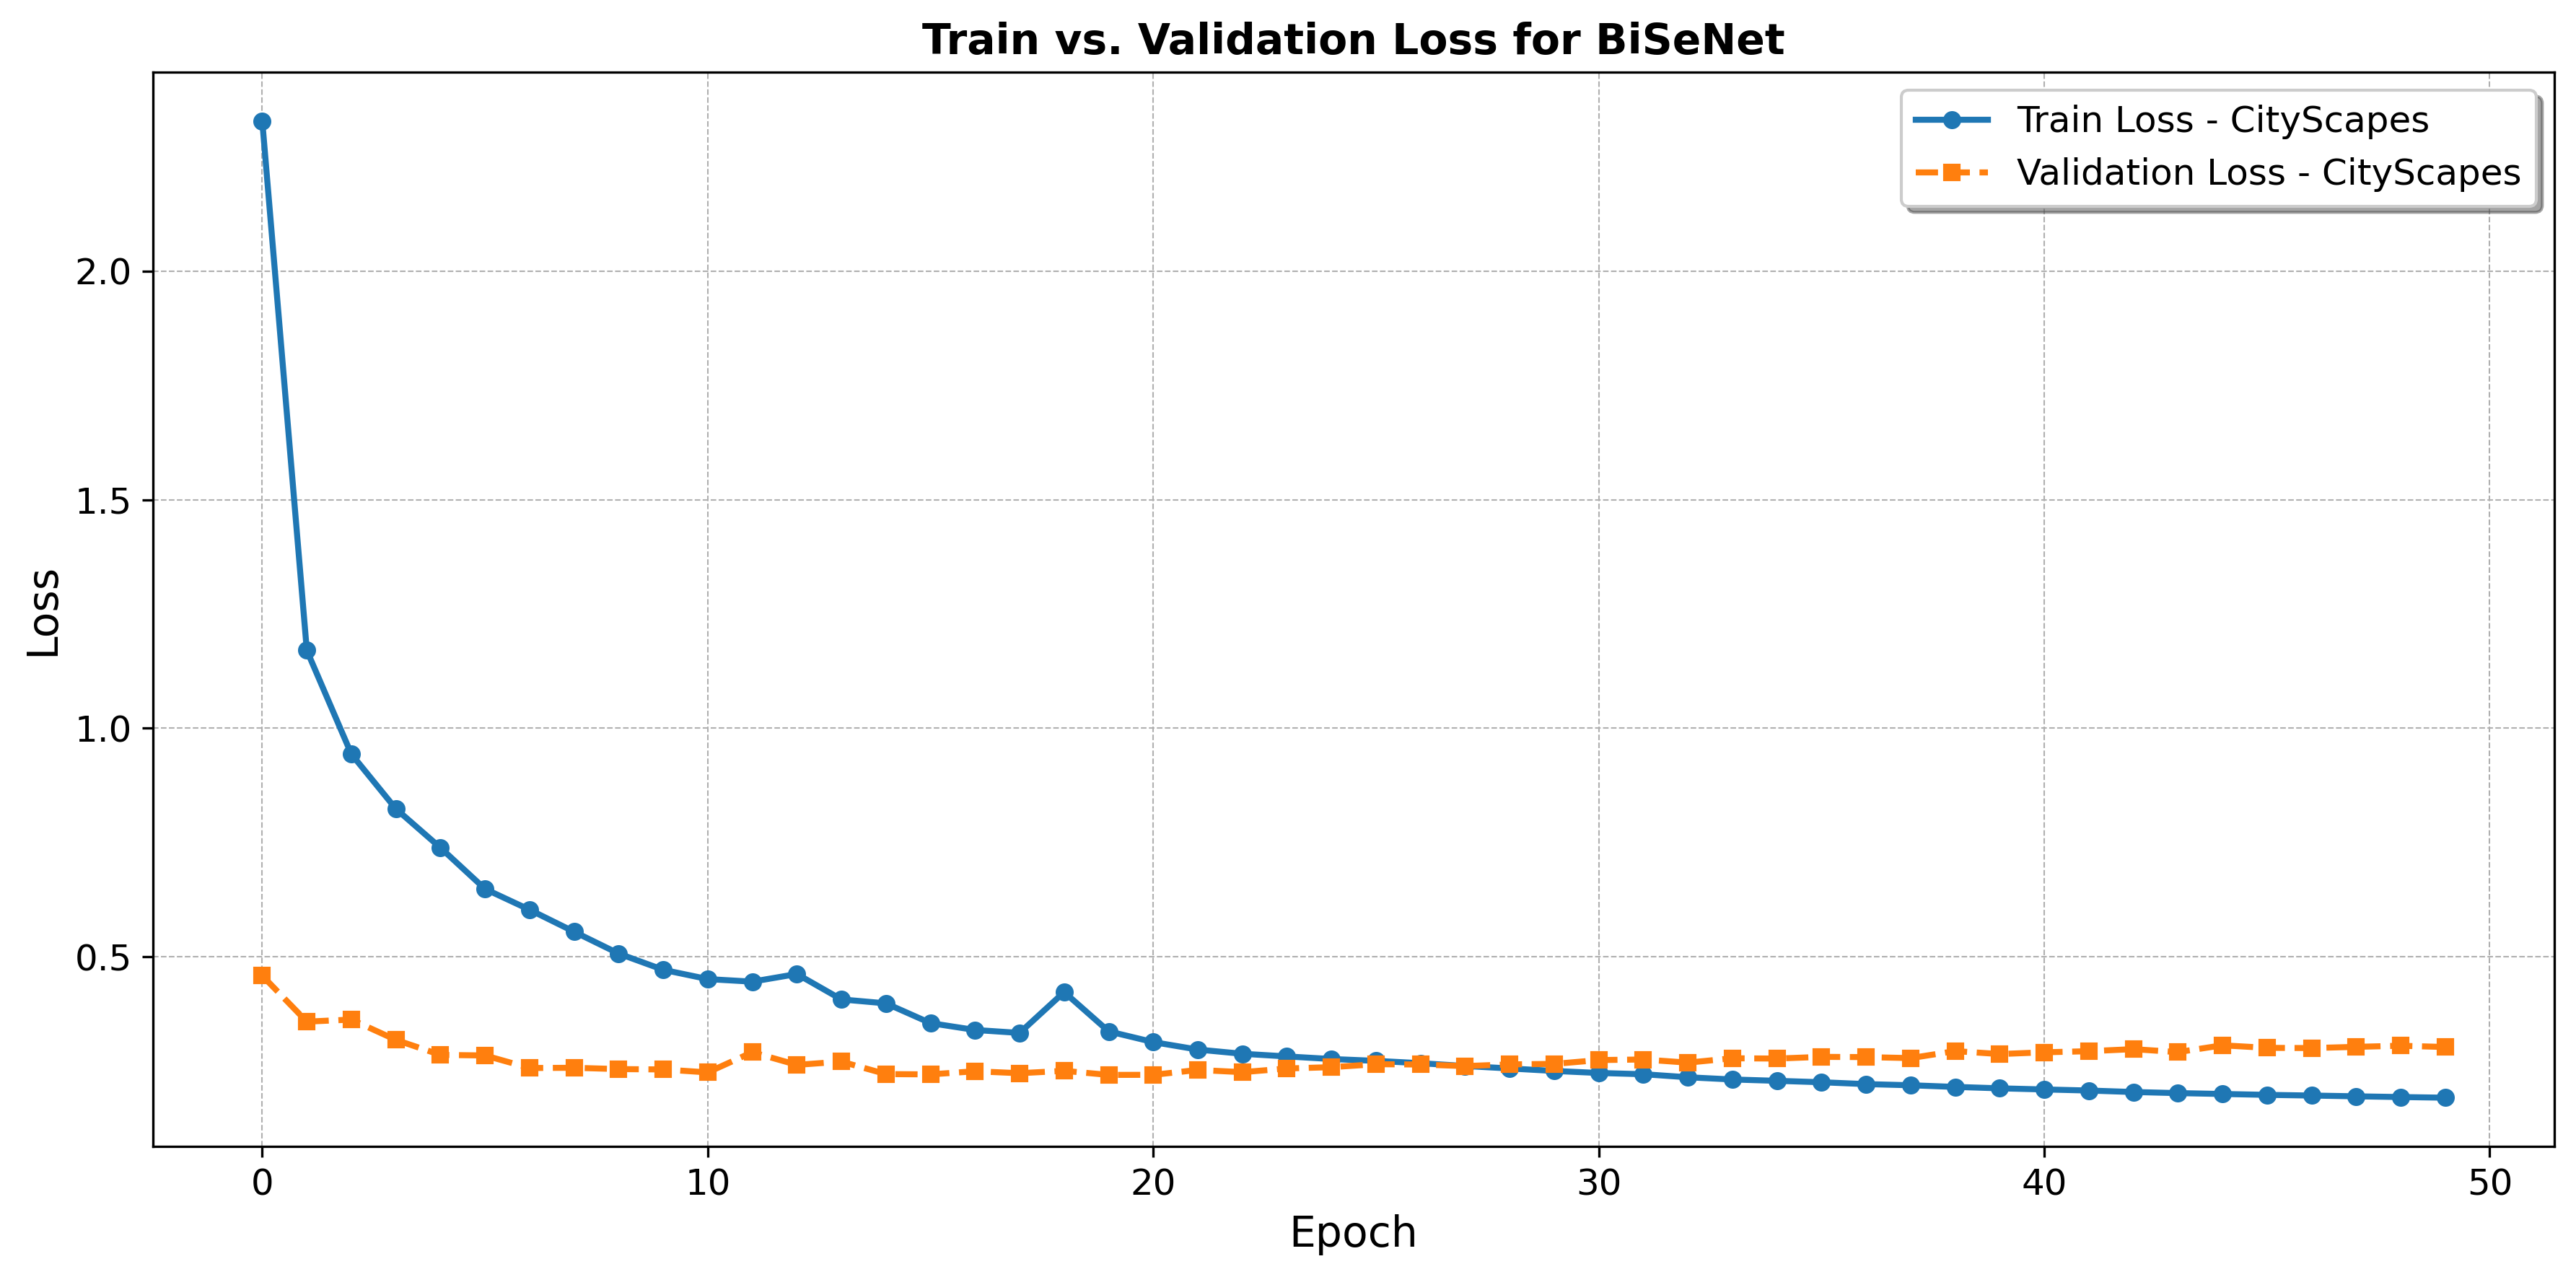

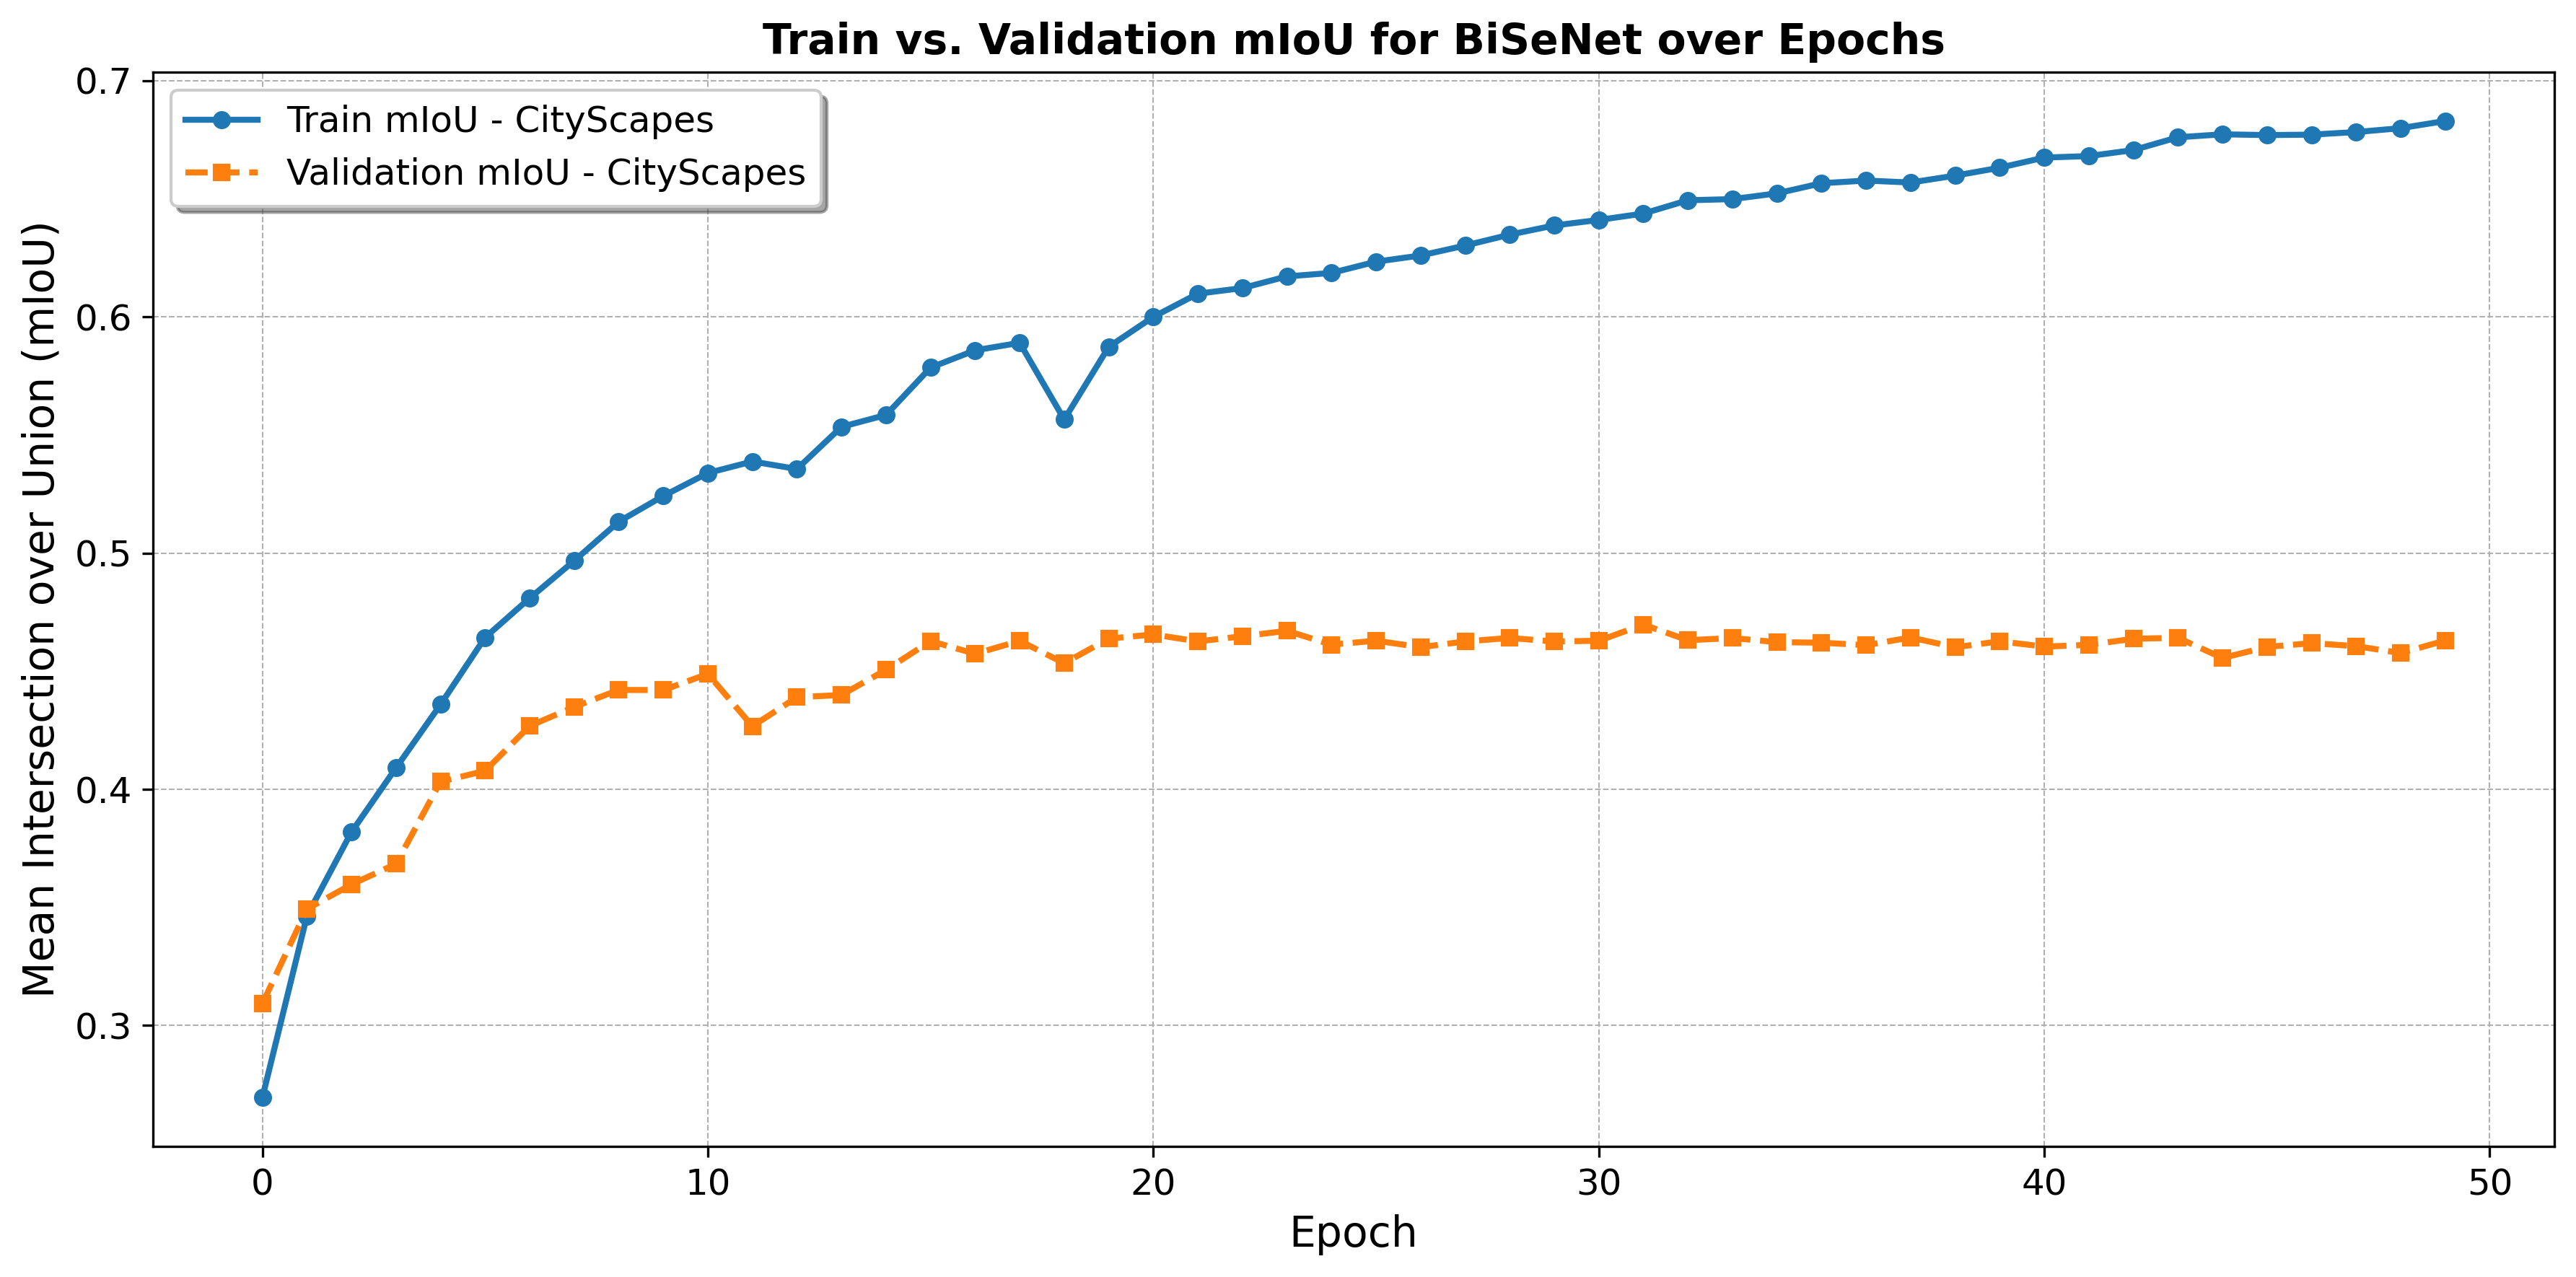

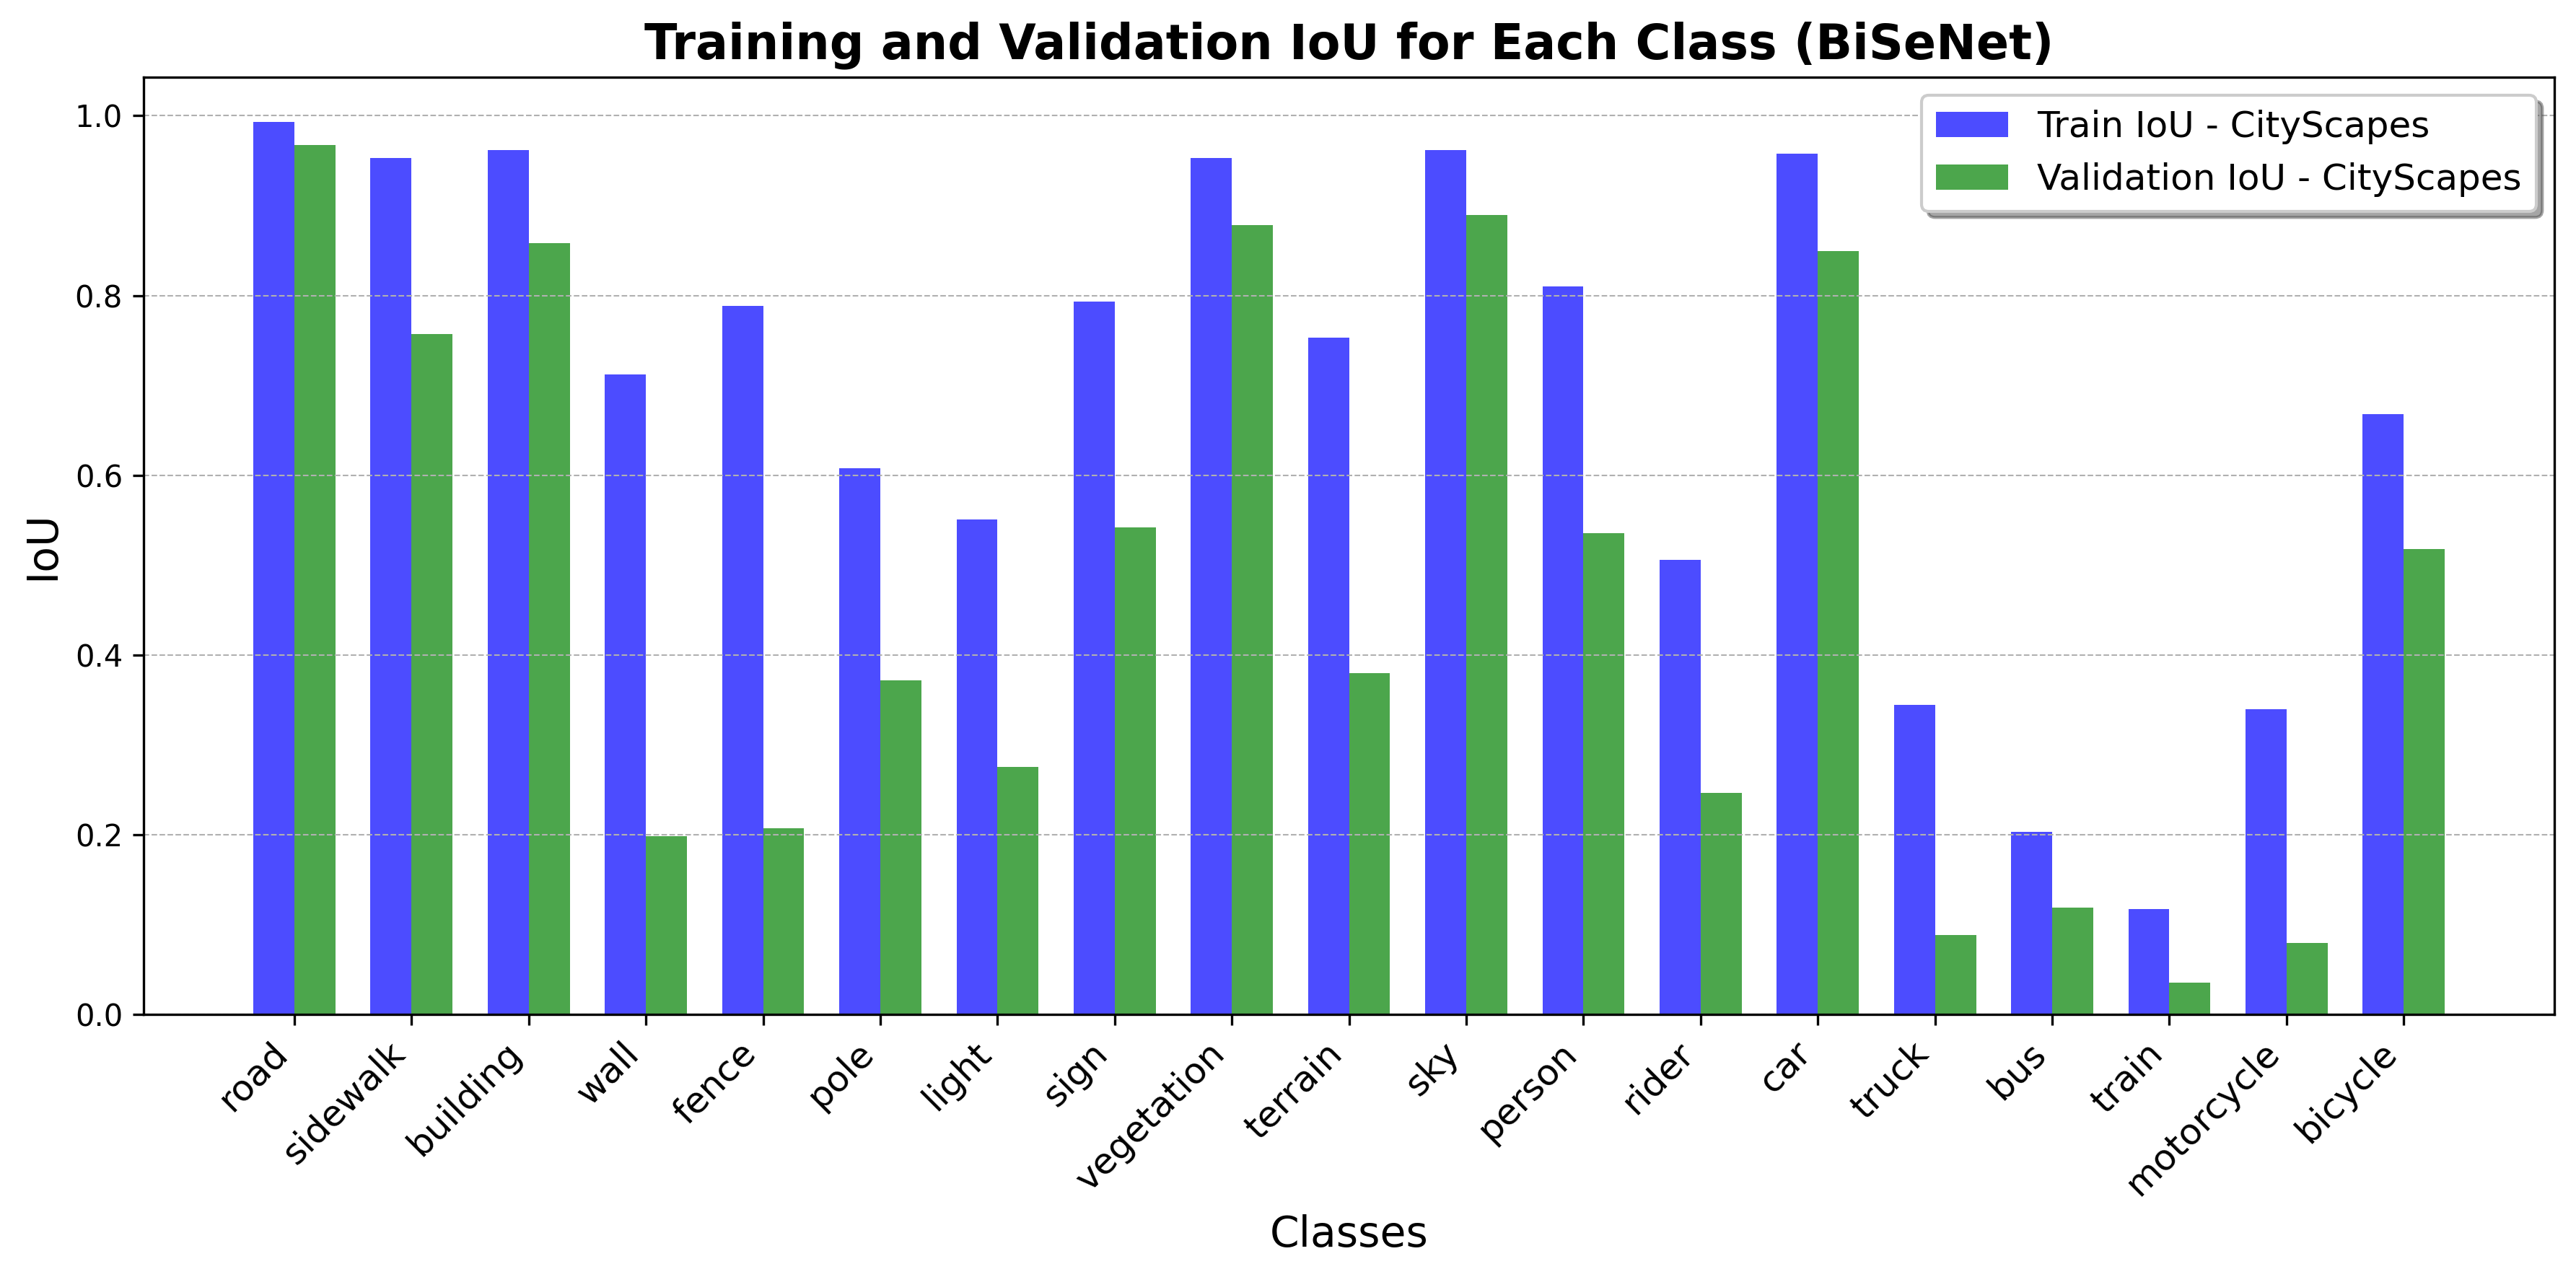

In [4]:

import importlib
import model_evaluation
importlib.reload(model_evaluation)
from model_evaluation import save_results
model_bisenet.eval()
save_results(model_bisenet, bisenet_result_2_2, "bisenet_adam_performance_metrics_2_2", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100)
plot_loss(bisenet_result_2_2, "BiSeNet", "step2_2_adam", "CityScapes", "CityScapes")
plot_mIoU(bisenet_result_2_2, "BiSeNet", "step2_2_adam", "CityScapes", "CityScapes")
plot_IoU(bisenet_result_2_2, "BiSeNet", "step2_2_adam", "CityScapes", "CityScapes")
torch.save(model_bisenet.state_dict(), "./checkpoints/bisenet_adam_model_2_2.pth")



## 3.1 Bisenet

In [5]:
model_bisenet_3_1 = BiSeNet(19, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet_3_1 = torch.nn.DataParallel(model_bisenet_3_1).to(device)
init_lr = 2.5e-4
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer_bisenet_3_1 = torch.optim.Adam(model_bisenet_3_1.parameters(), lr=init_lr)
bisenet_result_3_1 = train(model=model_bisenet_3_1,
                           optimizer=optimizer_bisenet_3_1,
                           loss_fn=loss_fn,
                           train_dataloader=GTA5_dataloader,
                           validation_dataloader=cityscapes_test_dataloader,
                           epochs=EPOCHS,
                           device=device,
                           model_name="bisenet",
                           class_number=NC)



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.5006600695610046, Validation Loss: 2.308731771469116
Train mIoU: 0.26060681462465984, Validation mIoU: 0.13659346229915803
Epoch: 1
Train Loss: 0.2909672470569611, Validation Loss: 2.5030039854049684
Train mIoU: 0.33749224878285905, Validation mIoU: 0.15325650492242854
Epoch: 2
Train Loss: 0.24319394783973694, Validation Loss: 2.436782751083374
Train mIoU: 0.37154209271413574, Validation mIoU: 0.14037846081860608
Epoch: 3
Train Loss: 0.2147186807155609, Validation Loss: 2.612187315940857
Train mIoU: 0.3950367504642892, Validation mIoU: 0.15411321003303585
Epoch: 4
Train Loss: 0.19914708909988404, Validation Loss: 2.5801937370300294
Train mIoU: 0.4101552720655474, Validation mIoU: 0.13915281312374447
Epoch: 5
Train Loss: 0.18519000606536865, Validation Loss: 3.161395993232727
Train mIoU: 0.42446346868570833, Validation mIoU: 0.13481821538117422
Epoch: 6
Train Loss: 0.17707924352884294, Validation Loss: 2.2552463579177857
Train mIoU: 0.4331985366905853, Validation 

KeyboardInterrupt: 

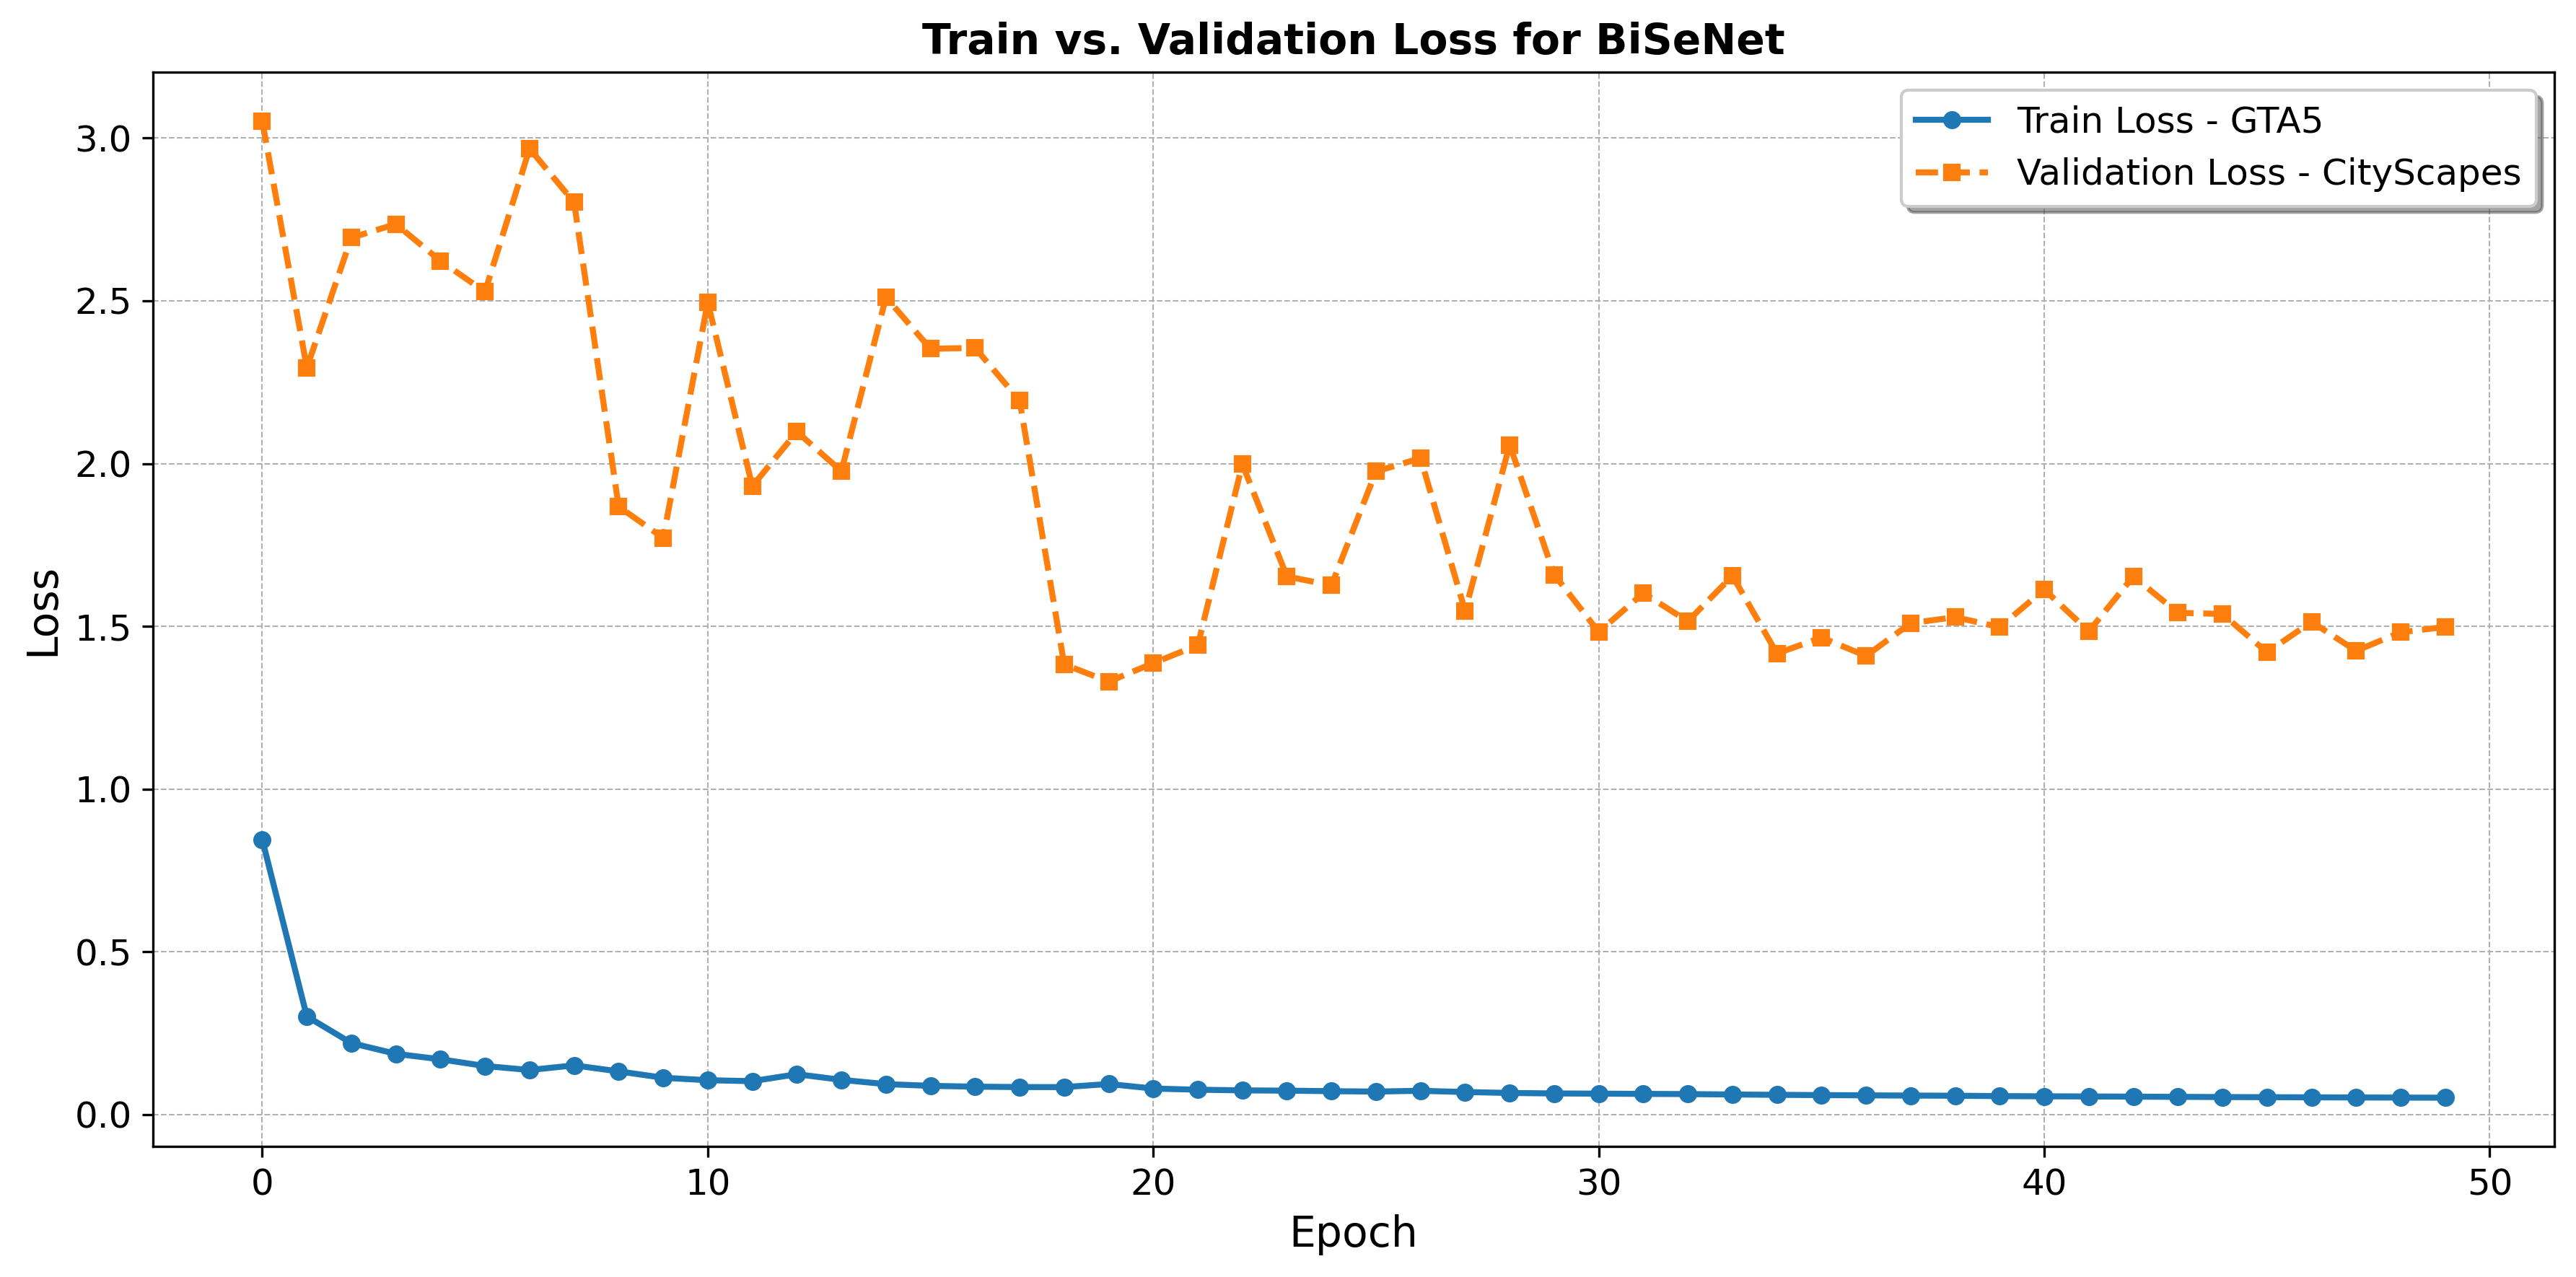

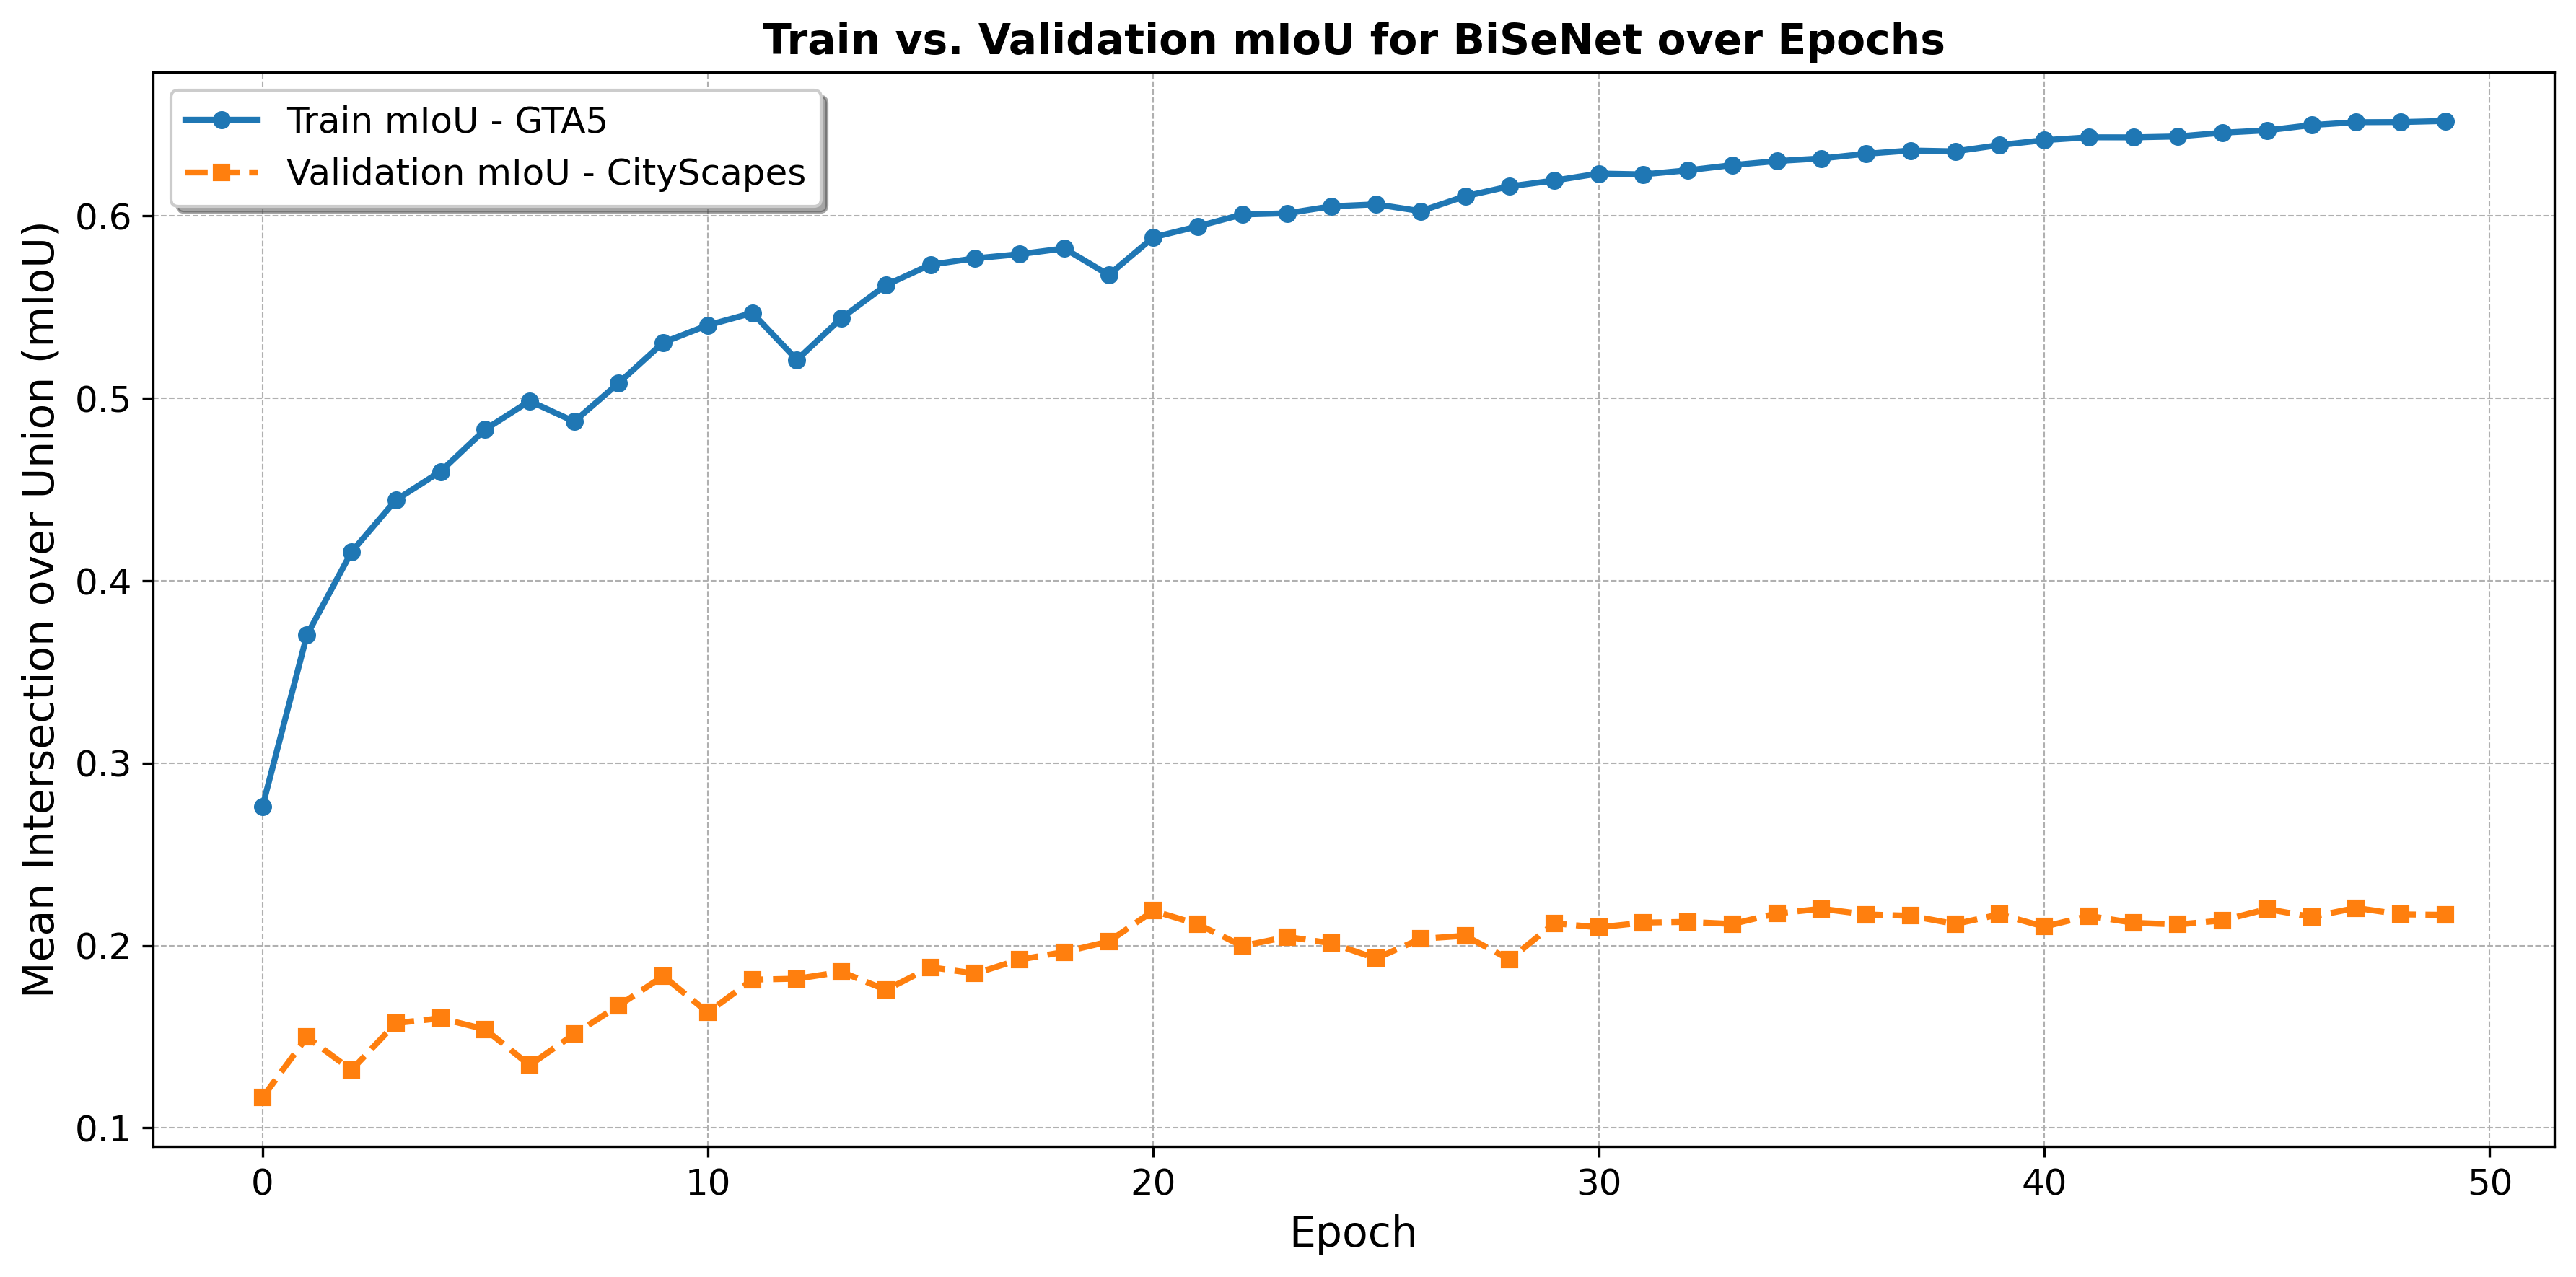

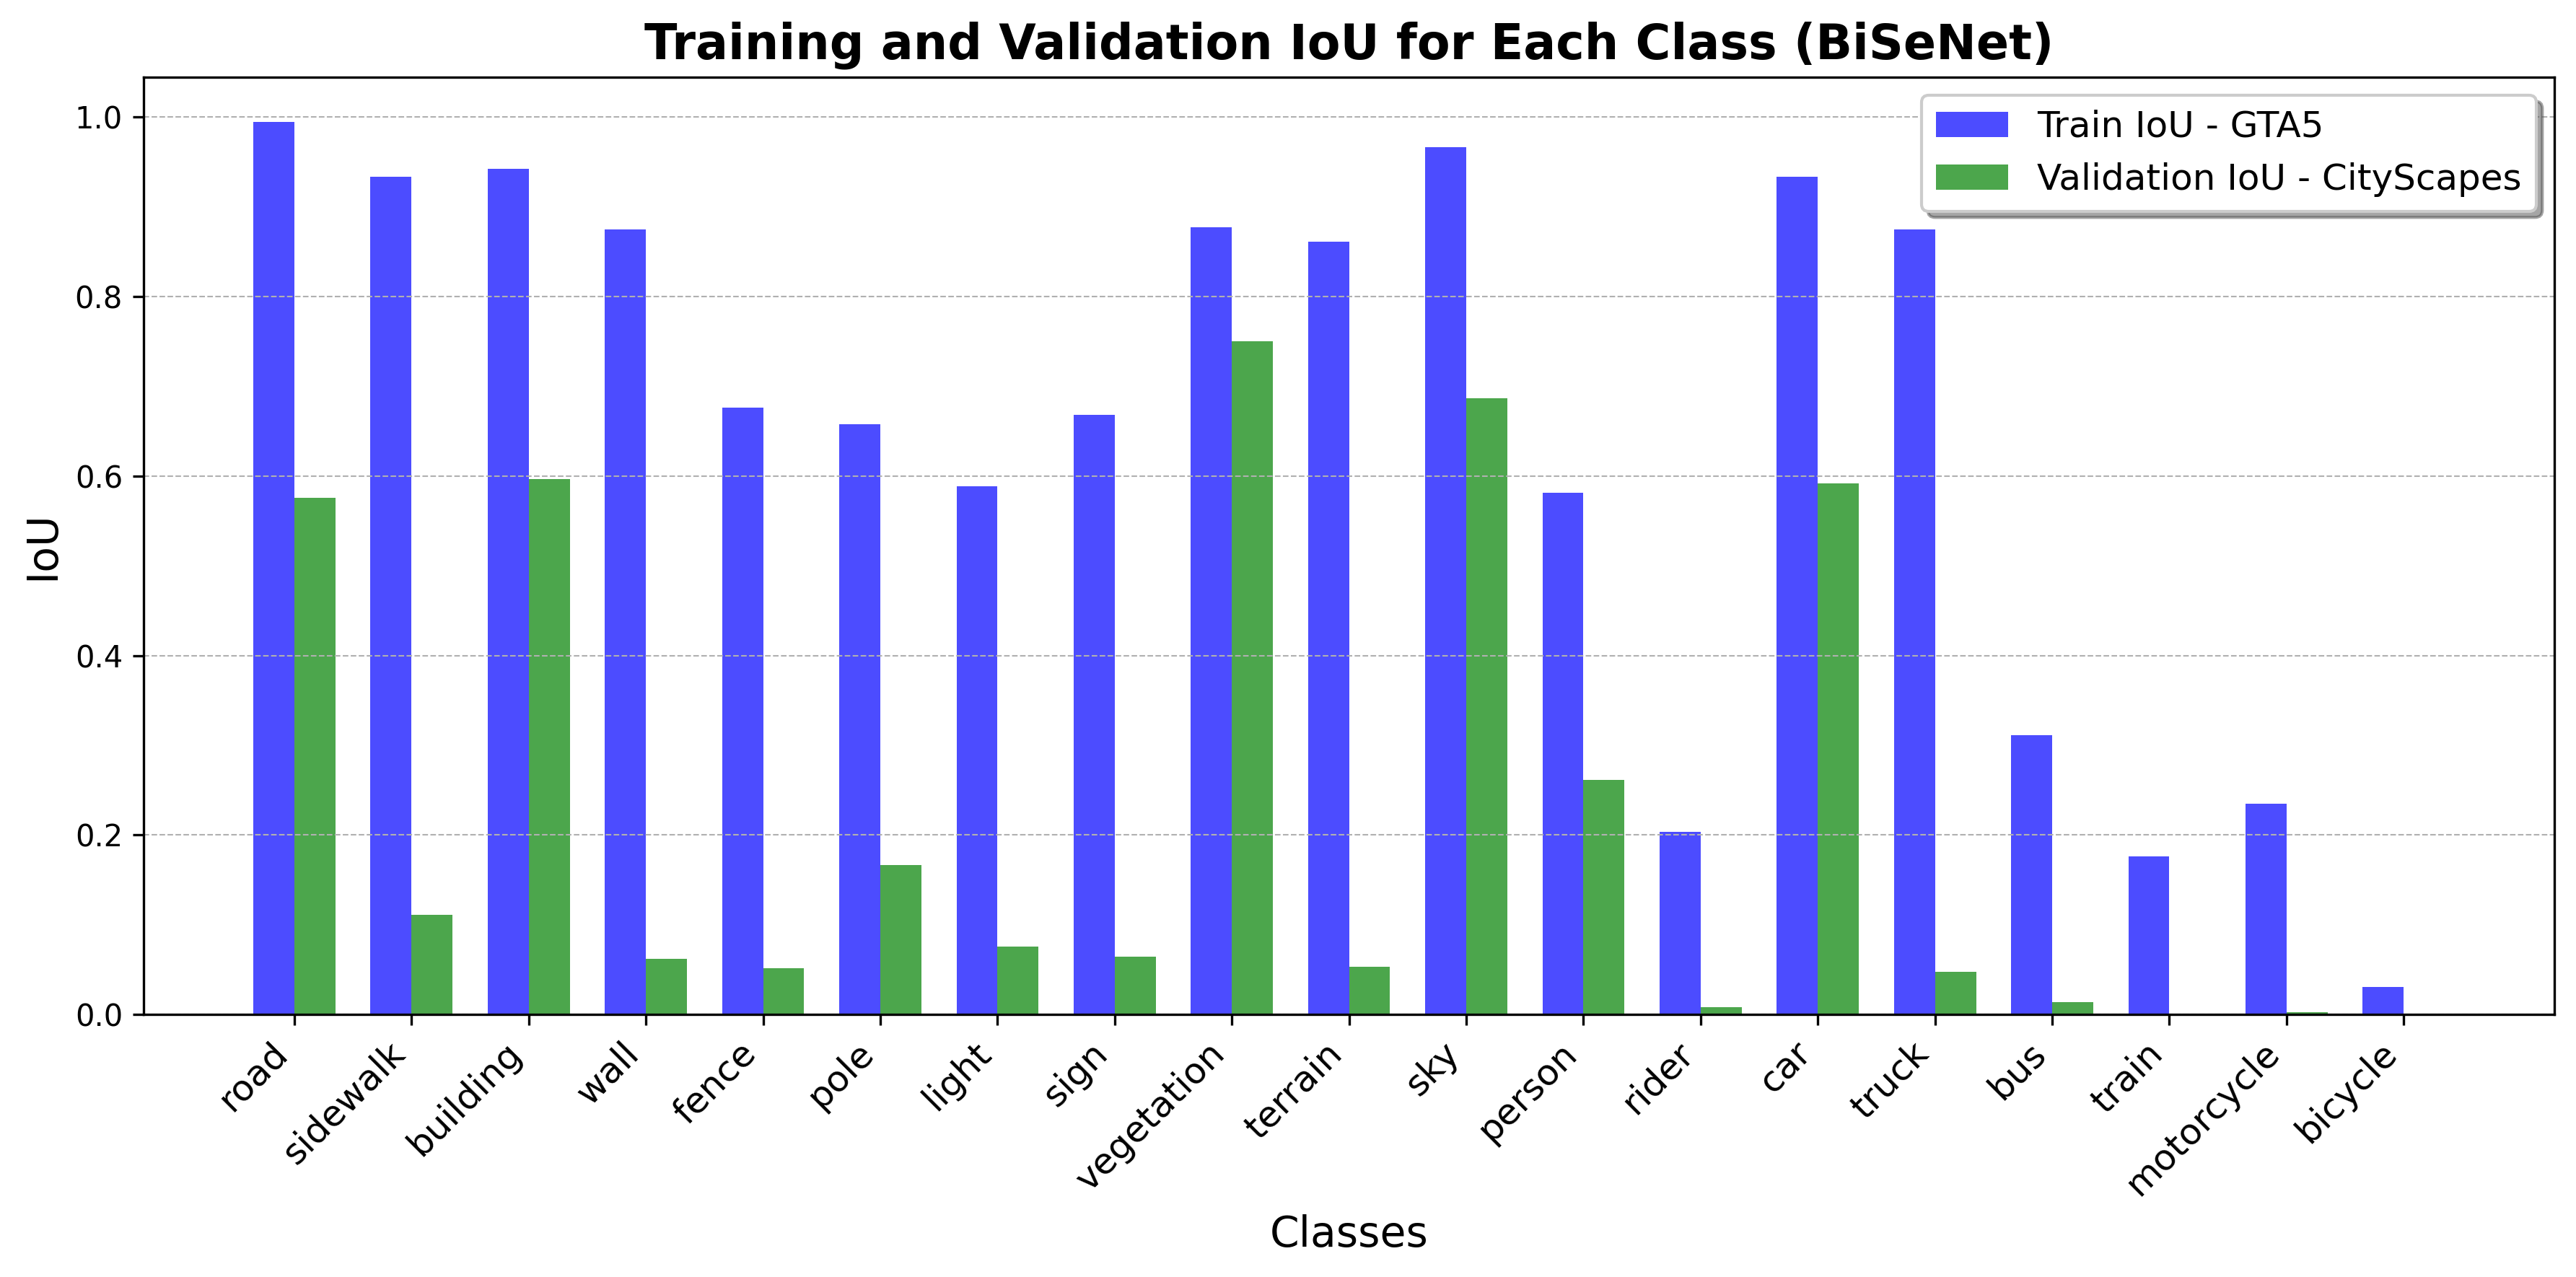

In [4]:
save_results(model_bisenet_3_1, bisenet_result_3_1, "bisenet_adam_performance_metrics_3_1", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=1000, device=device)
plot_loss(bisenet_result_3_1, "BiSeNet", "step3_1_adam", "GTA5", "CityScapes")
plot_mIoU(bisenet_result_3_1, "BiSeNet", "step3_1_adam", "GTA5", "CityScapes")
plot_IoU(bisenet_result_3_1, "BiSeNet", "step3_1_adam", "GTA5", "CityScapes")
torch.save(model_bisenet_3_1.state_dict(), "./checkpoints/bisenet_adam_model_3_1.pth")



## 3.2 Bisenet with augmentation



In [7]:
init_lr = 2.5e-4

augmentations = {
    # 'transform1': A.Compose([
    #     A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
    #     A.HorizontalFlip(p=0.5),
    #     A.ColorJitter(p=0.5),

    # ]),
    'transform2': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.ColorJitter(p=0.5),
        A.GaussianBlur(p=0.5),

    ]),
    # 'transform3': A.Compose([
    #     A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
    #     A.HorizontalFlip(p=0.5),
    #     A.GaussianBlur(p=0.5),
    # ]),
    # 'transform4': A.Compose([
    #     A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
    #     A.ColorJitter(p=0.5),
    #     A.GaussianBlur(p=0.5),
    #     A.GaussNoise(p=0.5),

    # ]),

}
best_score = 0
best_transform = ''

# Evaluate each augmentation strategy
for transform_name, transform_pipeline in augmentations.items():
    # Prepare datasets with the current transformation
    cityscapes_train_dataset = CityScapes('./Cityscapes', 'train', transform=transform_pipeline)
    cityscapes_test_dataset = CityScapes('./Cityscapes', 'val', transform=transform_pipeline)
    GTA5_dataset = GTA5('./GTA5', transform=transform_pipeline)

    # Create dataloaders
    cityscapes_train_dataloader = DataLoader(cityscapes_train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    cityscapes_test_dataloader = DataLoader(cityscapes_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    # Initialize model and optimizer
    model_bisenet_3_2 = BiSeNet(19, 'resnet18').to(device)
    if device == 'cuda' and torch.cuda.device_count() > 1:
        model_bisenet_3_2 = torch.nn.DataParallel(model_bisenet_3_2).to(device)
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
    optimizer = torch.optim.Adam(model_bisenet_3_2.parameters(), lr=init_lr)

    # Train the model
    bisenet_result3_2 = train(model=model_bisenet_3_2,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              train_dataloader=GTA5_dataloader,
                              validation_dataloader=cityscapes_test_dataloader,
                              epochs=EPOCHS,
                              device=device,
                              model_name="bisenet",
                              class_number=NC)
    
    # Save and plot results
    save_results(model_bisenet_3_2, bisenet_result3_2, f"bisenet_adam_performance_metrics_3_2_{transform_name}", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100, device=device)
    plot_loss(bisenet_result3_2, "BiSeNet", f"step3_2_adam_{transform_name}", "GTA5", "CityScapes")
    plot_mIoU(bisenet_result3_2, "BiSeNet", f"step3_2_adam_{transform_name}", "GTA5", "CityScapes")
    plot_IoU(bisenet_result3_2, "BiSeNet", f"step3_2_adam_{transform_name}", "GTA5", "CityScapes")
    
    # Save model checkpoint
    torch.save(model_bisenet_3_2.state_dict(), f"./checkpoints/bisenet_adam_model_3_2_{transform_name}.pth")
    
    # Update best performing transformation
    if best_score < bisenet_result3_2[3][-1]:
        best_score = bisenet_result3_2[3][-1]
        best_transform = transform_name

best_transform


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.9753879452705383, Validation Loss: 1.2068427410125733
Train mIoU: 0.2554264541866458, Validation mIoU: 0.1764437822057362
Epoch: 1
Train Loss: 1.0547364527702332, Validation Loss: 1.2246830940246582
Train mIoU: 0.31919568197612946, Validation mIoU: 0.17561508947919885
Epoch: 2
Train Loss: 0.8663270282268524, Validation Loss: 1.228278980731964
Train mIoU: 0.3564192016685966, Validation mIoU: 0.1968992858974301
Epoch: 3
Train Loss: 0.757154412651062, Validation Loss: 1.1783981003761292
Train mIoU: 0.39164510941266006, Validation mIoU: 0.1930666067268996
Epoch: 4
Train Loss: 0.6822852087497712, Validation Loss: 0.9606506752967835
Train mIoU: 0.41885701878057346, Validation mIoU: 0.22564726302228533
Epoch: 5
Train Loss: 0.6226704211711883, Validation Loss: 1.5770443758964539
Train mIoU: 0.44115902348657354, Validation mIoU: 0.1888357354292165
Epoch: 6
Train Loss: 0.5959237969875336, Validation Loss: 1.5599716806411743
Train mIoU: 0.45111585147312067, Validation mIoU:

KeyboardInterrupt: 

# 4.1 FDA

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.9997929824829102, Validation Loss: 1.2158132076263428
Train mIoU: 0.2058103988495594, Validation mIoU: 0.16167303969462787
Epoch: 1
Train Loss: 1.3176517175674438, Validation Loss: 0.9345273733139038
Train mIoU: 0.2730645714722308, Validation mIoU: 0.19151341436036673
Epoch: 2
Train Loss: 1.132640972137451, Validation Loss: 0.815725615978241
Train mIoU: 0.3028385679264899, Validation mIoU: 0.20400568694759316
Epoch: 3
Train Loss: 1.0199364496231078, Validation Loss: 1.0362905173301697
Train mIoU: 0.32923346238054757, Validation mIoU: 0.20321589958914626
Epoch: 4
Train Loss: 0.9397161958694458, Validation Loss: 0.801277708530426
Train mIoU: 0.35243101695097095, Validation mIoU: 0.22959700226430318
Epoch: 5
Train Loss: 0.8687402039527893, Validation Loss: 0.8335680379867554
Train mIoU: 0.370712219317749, Validation mIoU: 0.23253922862596865
Epoch: 6
Train Loss: 0.8037378812789917, Validation Loss: 0.768799255847931
Train mIoU: 0.3901880856374111, Validation mIoU: 0

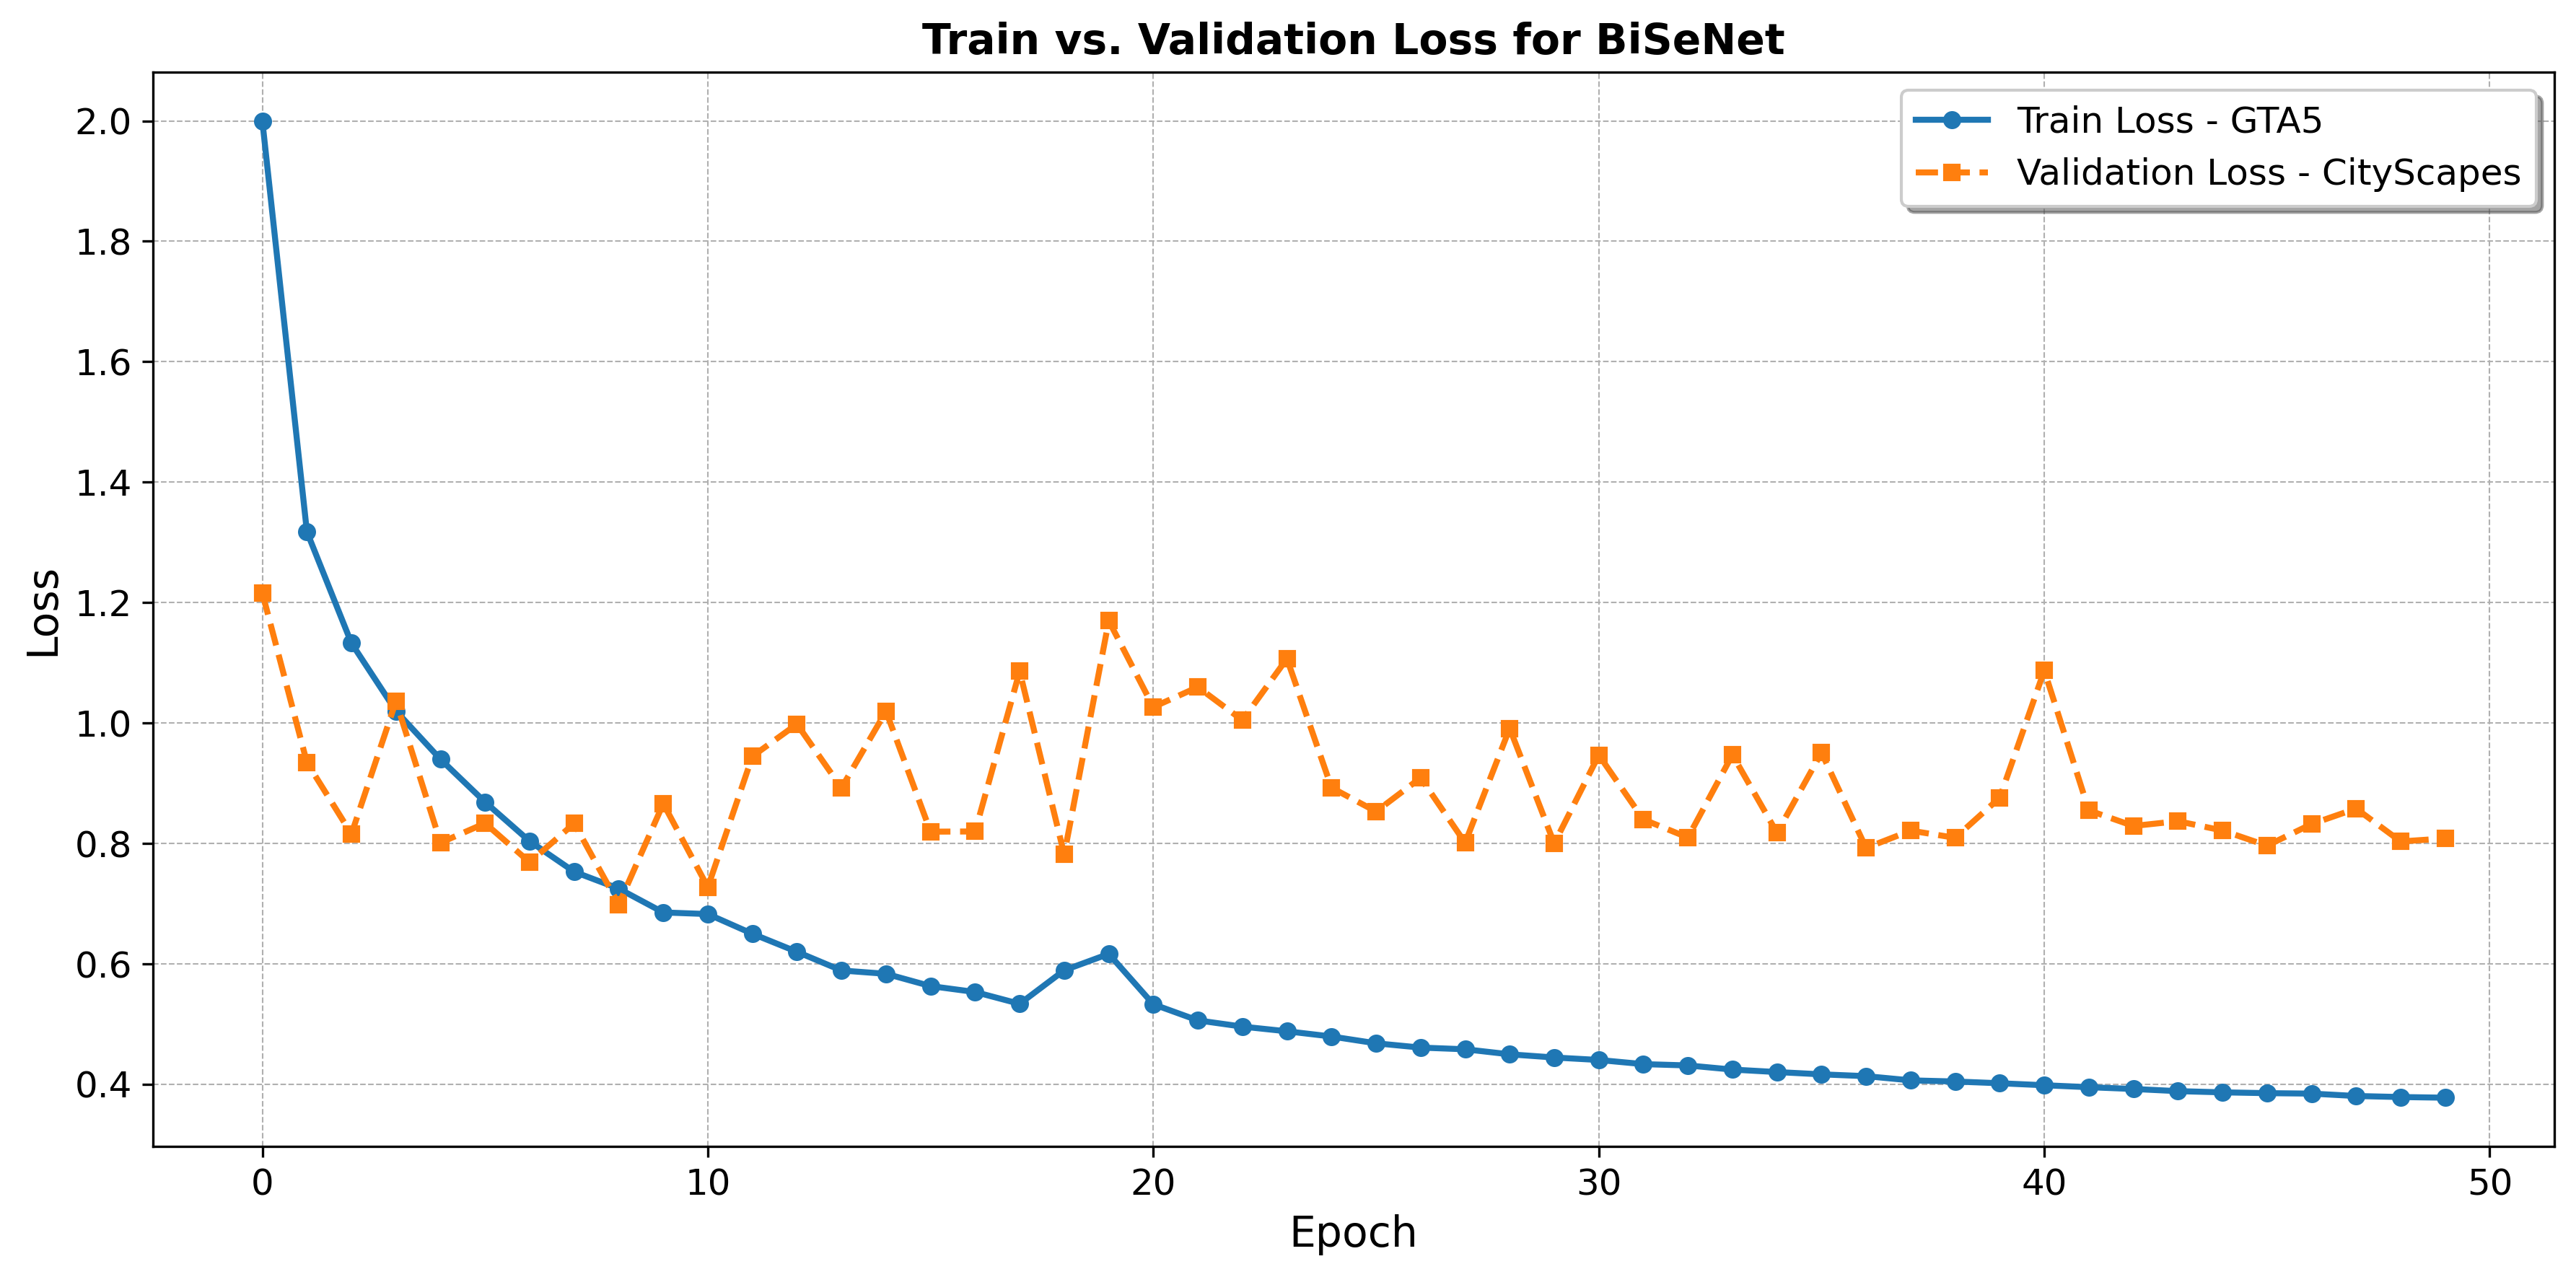

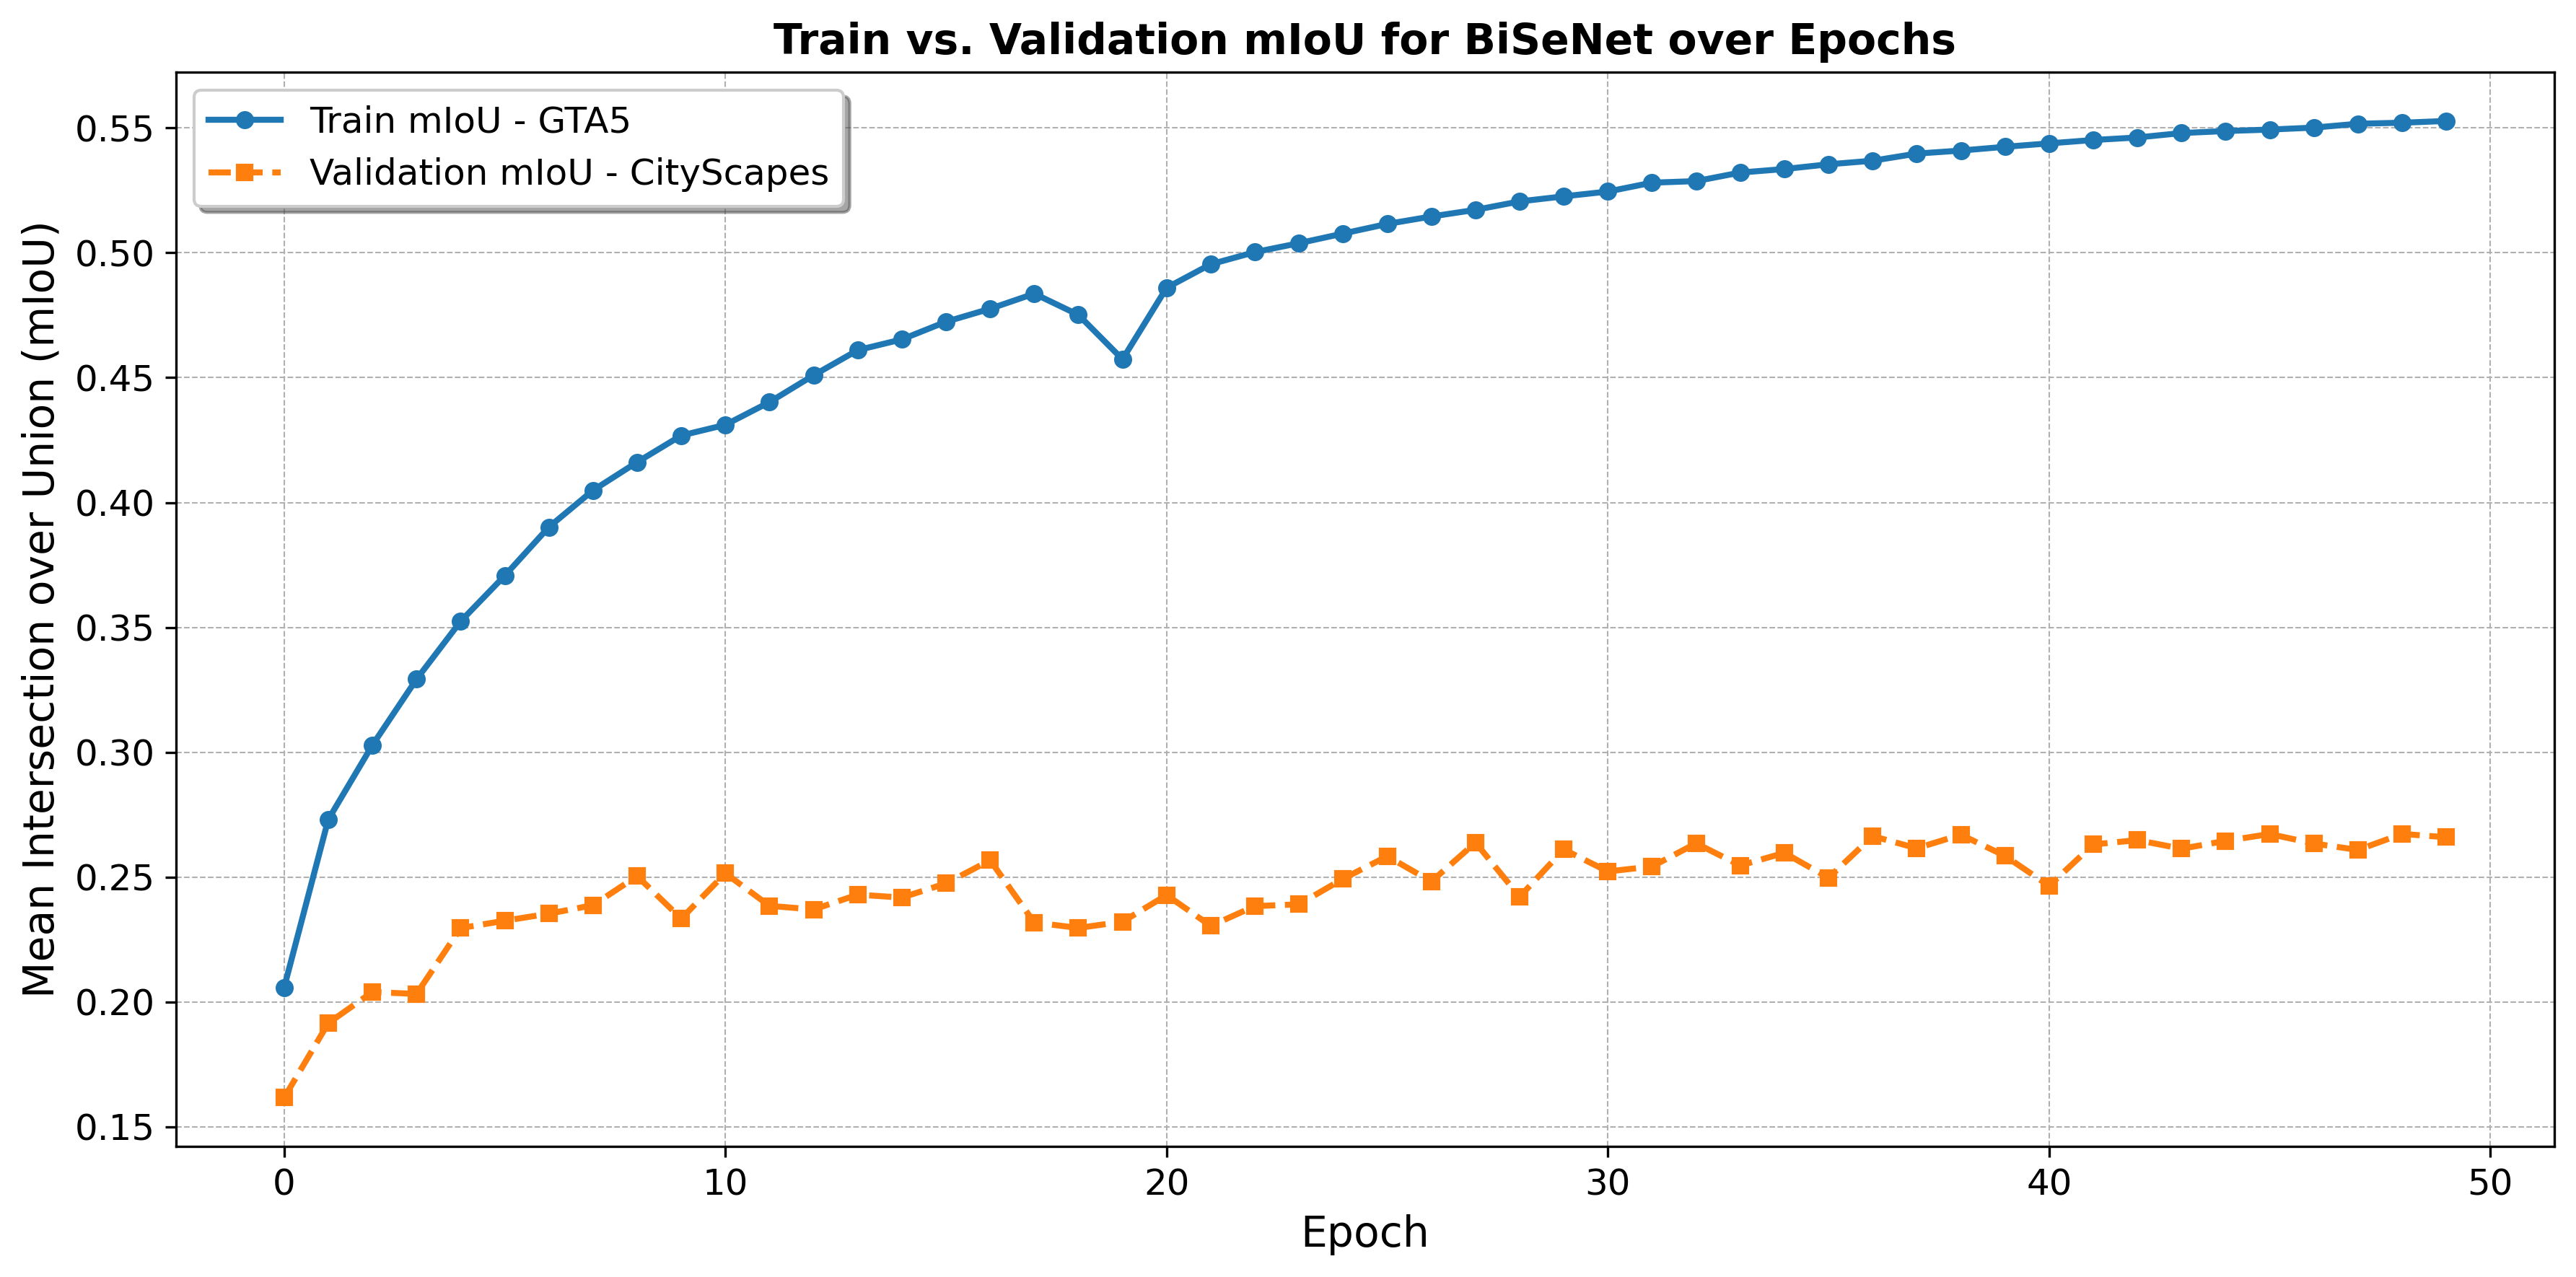

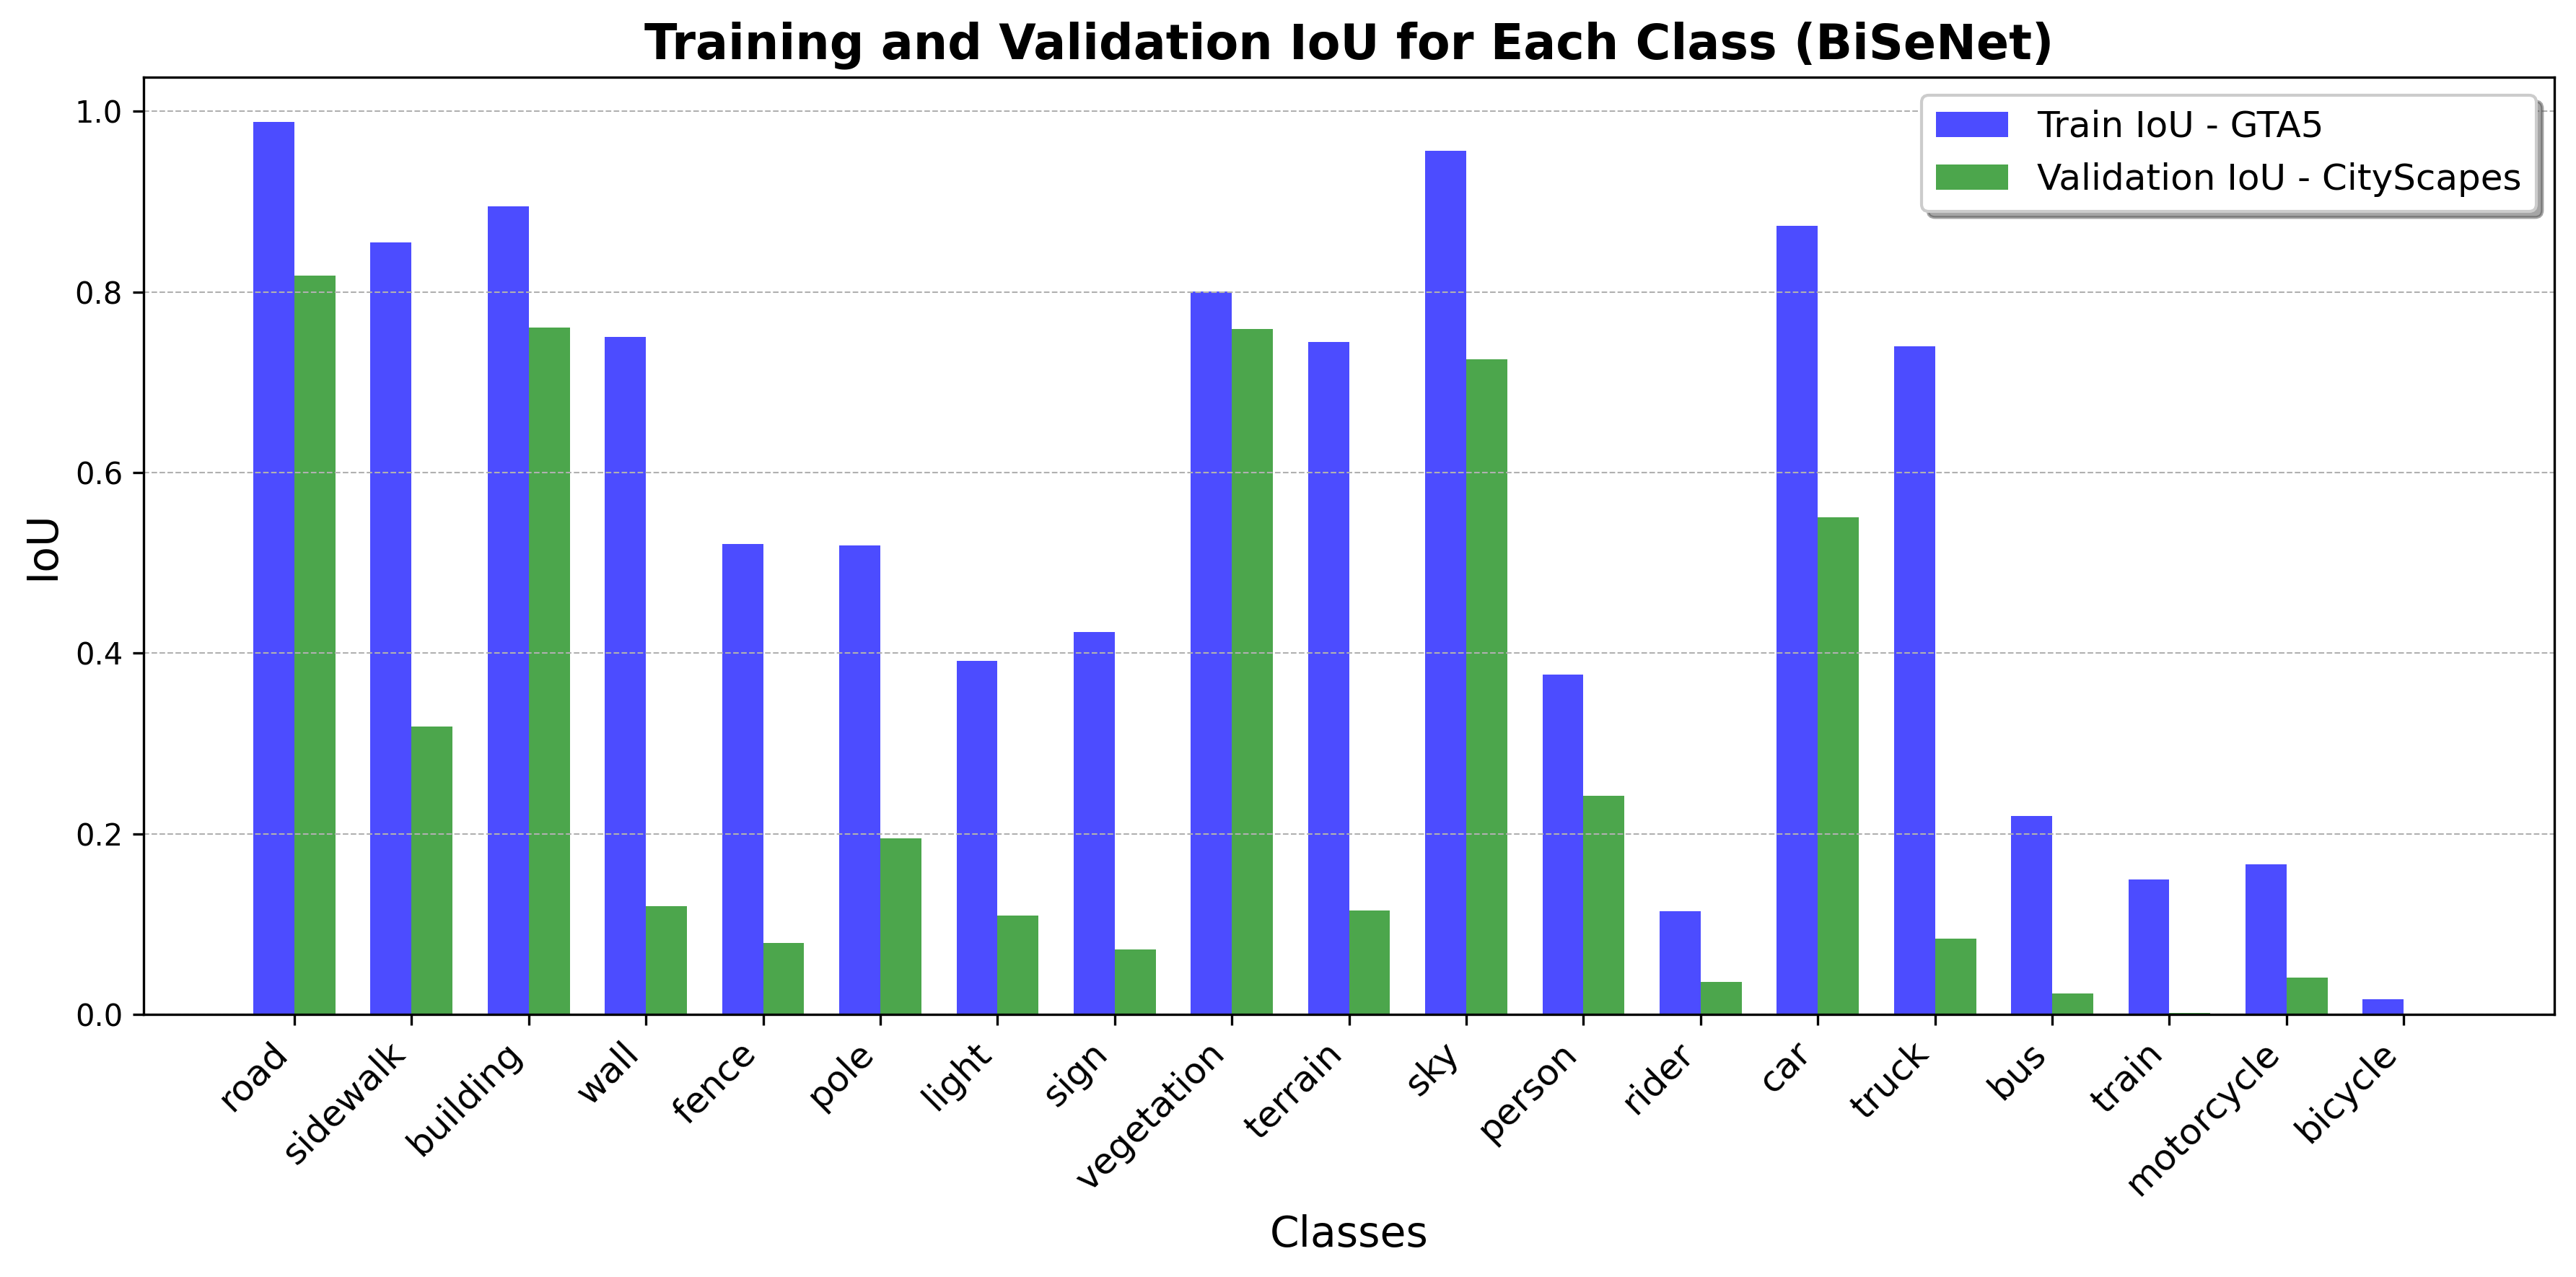

In [3]:

augmentations = {
    'transform1': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.5),

    ]),
    'transform2': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.ColorJitter(p=0.5),
        A.GaussianBlur(p=0.5),

    ]),
    'transform3': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.GaussianBlur(p=0.5),
    ]),
    'transform4': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.ColorJitter(p=0.5),
        A.GaussianBlur(p=0.5),
        A.GaussNoise(p=0.5),

    ]),

}
GTA5_dataset = GTA5('./GTA5', transform=augmentations['transform2'], FDA = 0.09)
GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

model_bisenet_4_1_FDA = BiSeNet(19, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet_4_1_FDA = torch.nn.DataParallel(model_bisenet_4_1_FDA).to(device)
init_lr = 2.5e-2 #0.0001
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.SGD(model_bisenet_4_1_FDA.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)

bisenet_result4_1_FDA = train(model = model_bisenet_4_1_FDA,
                              optimizer = optimizer,
                              loss_fn = loss_fn,
                              train_dataloader = GTA5_dataloader,
                              validation_dataloader = cityscapes_test_dataloader,
                              epochs = EPOCHS,
                              device = device,
                              model_name = "bisenet",
                              class_number= NC)

    
save_results(model_bisenet_4_1_FDA, bisenet_result4_1_FDA, "bisenet_sgd_performance_metrics_4_1_FDA", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100, device=device)
plot_loss(bisenet_result4_1_FDA, "BiSeNet", "step4_1_sgd_FDA", "GTA5", "CityScapes")
plot_mIoU(bisenet_result4_1_FDA, "BiSeNet", "step4_1_sgd_FDA", "GTA5", "CityScapes")
plot_IoU(bisenet_result4_1_FDA, "BiSeNet", "step4_1_sgd_FDA", "GTA5", "CityScapes")
torch.save(model_bisenet_4_1_FDA.state_dict(), f"./checkpoints/bisenet_sgd_model_4_1_FDA.pth")


# 4.2 DACS

1- In the paper they say that they are using pretrained model. but in pseudocode they say that they are initializing the model with random parameters.


In [3]:

augmentations = {
    'transform1': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.5),

    ]),
    'transform2': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.ColorJitter(p=0.5),
        A.GaussianBlur(p=0.5),

    ]),
    'transform3': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.GaussianBlur(p=0.5),
    ]),
    'transform4': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.ColorJitter(p=0.5),
        A.GaussianBlur(p=0.5),
        A.GaussNoise(p=0.5),

    ]),

}
# GTA5_dataset = GTA5('./GTA5', transform=augmentations[best], FDA = 0.09)
GTA5_dataset = GTA5('./GTA5', transform=augmentations['transform2'])
GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=2, shuffle=False, num_workers=NUM_WORKERS)
# GTA5_dataset = GTA5('./GTA5', transform=augmentations[best_transform], FDA = 0.09)

# GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
model_bisenet_4_2_DACS = BiSeNet(NC, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet_4_2_DACS = torch.nn.DataParallel(model_bisenet_4_2_DACS).to(device)
init_lr = 2.5e-4
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model_bisenet_4_2_DACS.parameters(), lr=init_lr)

bisenet_result4_2_DACS = train(model = model_bisenet_4_2_DACS,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               train_dataloader= GTA5_dataloader,
                               validation_dataloader=cityscapes_test_dataloader,
                               target_dataloader=cityscapes_train_dataloader,
                               epochs=EPOCHS,
                               device = device,
                               model_name='bisenet',
                               )
save_results(model_bisenet_4_2_DACS, bisenet_result4_2_DACS, "bisenet_sgd_performance_metrics_4_2_DACS", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100, device=device)
plot_loss(bisenet_result4_2_DACS, "BiSeNet_sgd", "step4_2_DACS", "GTA5 + CityScapes (DACS)", "CityScapes")
plot_mIoU(bisenet_result4_2_DACS, "BiSeNet_sgd", "step4_2_DACS", "GTA5 + CityScapes (DACS)", "CityScapes")
plot_IoU(bisenet_result4_2_DACS, "BiSeNet_sgd", "step4_2_DACS", "GTA5 + CityScapes (DACS)", "CityScapes")

torch.save(model_bisenet_4_2_DACS.state_dict(), "./checkpoints/bisenet_sgd_model_4_2_DACS.pth")


  0%|          | 0/50 [00:00<?, ?it/s]

Processing image 0.0952, ----- 46.59018325805664
Processing image 0.1912, ----- 45.89629530906677
Processing image 0.2872, ----- 45.24119782447815
Processing image 0.3832, ----- 44.58058571815491
Processing image 0.4792, ----- 44.661468744277954
Processing image 0.5752, ----- 45.53715467453003
Processing image 0.6712, ----- 45.17066240310669
Processing image 0.7672, ----- 45.24818134307861
Processing image 0.8632, ----- 45.006531953811646
Processing image 0.9592, ----- 46.384198904037476
Epoch: 0
Train Loss: 2.887116986346245, Validation Loss: 1.5141713275909423
Train mIoU: 0.09424989502890446, Validation mIoU: 0.09516052805145506
Processing image 0.0952, ----- 45.060778856277466
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/arda/anaconda3/envs/SEMSEG/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_482397/2980932541.py", line 42, in <module>
    bisenet_result4_2_DACS = train(model = model_bisenet_4_2_DACS,
  File "/home/arda/Documents/MLDL/semseg/MLDL2024_project1/training/train_engine.py", line 282, in train
    for epoch in tqdm(range(epochs)):
  File "/home/arda/Documents/MLDL/semseg/MLDL2024_project1/training/train_engine.py", line 163, in train_step_dacs
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arda/anaconda3/envs/SEMSEG/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/arda/anaconda3/envs/SEMSEG/lib/python3.9/site-packages/IPython/core/ultr